In [6]:
import pandas as pd 
import numpy as np 
import openmatrix as omx
from shutil import copytree, rmtree
import yaml
import logging
import os
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'/home/ubuntu/activitysim/carb'

## Reduce transit fare [0 - 100%]

In [3]:
def create_new_directory(source, destination):
    """ Creates a copy of source (directory) in destination (another directory):
    Parameters
    -----------
    - source: directory path
    - destiantion: directory path 
    
    Returns 
    None 
    """
    logging.info('Create new model directory in {}'.format(destination))
    
    try:
        copytree(source, destination)
    except FileExistsError:
        print ('File {} already exist - Replacing file'.format(destination))
        rmtree(destination)
        copytree(source, destination)


def transit_fare_reduction(skims_path, reduction, modes = None):
    ''' 
    Reduces transit fare by reduction 
    Parameters
    -----------
    - skims: skims file or path 
    - reduction: float. Number between 0 and 1
    - modes: str. Can be "bus", 'rail', 'lightrail' ## To add functionality
    '''
    assert 0<= reduction <=1, 'reduction parameter should be between zero and one'
    logging.info('Modifying transit skims for reduction{:.0f}'.format(reduction*100))
    
    skims = omx.open_file(skims_path,'a')
    skims_modified = omx.open_file(skims_path[:-4] + '_transit_fare_reduction.omx','w')

    matrices = skims.list_matrices()
    for matrix in matrices: 
        try:
            if 'FAR' in(matrix):
                skims_modified[matrix] = np.array(skims[matrix])*(1-reduction)
            else:
                skims_modified[matrix] = np.array(skims[matrix])
        except NodeError:
            pass 
    skims.close()
    skims_modified.close()
    
def modify_settings(settings_path, 
                    sample_size = 0, 
                    num_processes = 60,
                    skims_name = 'skims.omx'):
    
    ''' Modifies the settings.yaml file in the configs files'''
    logging.info('Modifying settings.yaml file')
    a_yaml_file = open(settings_path)
    settings = yaml.load(a_yaml_file, Loader=yaml.FullLoader)
    
    #Modify Settings
    settings['skims_file'] = skims_name
    settings['households_sample_size'] = sample_size
    settings['num_processes'] = num_processes
    
    with open(settings_path, 'w') as outfile:
        yaml.dump(settings, outfile, default_flow_style=False)

In [4]:
def create_scenario(source, destination, reductions, 
                    sample_size = 0, num_processes = 60):
    """
    Create folder to run scenarios 
    
    Parameters
    -----------
    - source: base line scenario path 
    - destination: folder name to store all other files
    - reductions: different scenarios reductions 
    - sample_size: Sample size for each scenario 
    """

    for scenario in reductions:
        #Create new directory
        name = 'reduction_{:.0f}'.format(scenario*100)
        
        #Check if file exist, if it doesn't exist create it 
        if os.path.exists(destination + name):
            replace = False
        else:
            replace = True

            
        if replace:
            #Create new directory for each scenario
            create_new_directory(source, destination + name)

            #Modify transit skims fare
            skims_path = destination + name + '/data/skims.omx'
            transit_fare_reduction(skims_path, scenario)

        #Modify Configs files
        settings_path = destination + name + '/configs/settings.yaml'
        modify_settings(settings_path, 
                        sample_size = sample_size, 
                        skims_name = 'skims_transit_fare_reduction.omx',
                        num_processes = num_processes)


In [5]:
sample_size = 200000
reductions = np.linspace(0, 1, 11) #From 0 to 100 % redcution every 10%
# reductions = [0, 0.1]
source = 'bay_area_base'
destination = 'transit/'
num_processes = 60

create_scenario(source, destination, reductions, 
                sample_size = sample_size, 
                num_processes = num_processes)

In [6]:
# sample_size = 200000
# reductions = [0, 0.1]
# replace = False
# source = 'bay_area_base'
# destination = 'transit/'


# for scenario in reductions:
#     #Create new directory
#     name = 'reduction_{:.0f}'.format(scenario*100)
    
#     if replace:
#         create_new_directory(source, destination + name)
    
#     #Modify transit skims fare
    
#     skims_path = destination + name + '/data/skims.omx'
#     transit_fare_reduction(skims_path, scenario)
    
#     #Modify Configs files
#     settings_path = destination + name + '/configs/settings.yaml'
#     modify_settings(settings_path, 
#                     sample_size = sample_size, 
#                     skims_name = 'skims_transit_fare_reduction.omx')


In [7]:
# skims_path = 'transit/reduction_10/data/skims.omx'
# reduction = 0.1

# skims = omx.open_file(skims_path,'a')
# skims_modified = omx.open_file(skims_path[:-4] + '_transit_fare_reduction.omx','w')

# matrices = skims.list_matrices()
# for matrix in matrices: 
#     try:
#         if 'FAR' in(matrix):
#             skims_modified[matrix] = np.array(skims[matrix])*(1-reduction)
#         else:
#             skims_modified[matrix] = np.array(skims[matrix])
#     except NodeError:
#         pass 

## Running models

In [23]:
path = 'transit'

In [24]:
path = 'transit'
models = os.listdir(path)
to_drop = ['.ipynb_checkpoints']
models = list(set(models) - set(to_drop))

In [10]:
# BE CAREFULL TO RUN THIS: IT TAKES 4 HOURS TO RUN! 
os.chdir(path)
for model in models:
    os.chdir(model)
    %run simulation.py
    os.chdir('../')

INFO - activitysim - Read logging configuration from: configs/logging.yaml
INFO - activitysim - setting households_sample_size: 200000
INFO - activitysim - setting chunk_size: 5000000000
INFO - activitysim - setting multiprocess: True
INFO - activitysim - setting num_processes: 60
INFO - activitysim - setting resume_after: None
DEBUG - activitysim.core.tracing - delete_output_files ignoring output/activitysim.log
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Setting num_processes = 0 for step mp_households
INFO - activitysim.core.pipeline - open_pipeline
INFO - activitysim.core.random - Set random seed base to 0
DEBUG - activitysim.core.pipeline - open_pipeline - new, empty pipeline
DEBUG - activitysim.core.pipeline - opened pipeline_store
DEBUG - activitysim.core.pipeline - add_checkpoint init timestamp 2021-05-20 04:29:25.514126
DEBUG - activitysim.core.pipeline - open_pipeline complete
INFO - activitysim.core.tracing - Time to execute open_pipeline : 0.019 seconds (0.0

/home/ubuntu/activitysim/activitysim/core/input.py:108: FutureWarning: table_inf option 'column_map' renamed 'rename_columns'Support for 'column_map' will be removed in future versions.
  warnings.warn("table_inf option 'column_map' renamed 'rename_columns'"


INFO - activitysim.core.tracing - Time to execute sub_process mp_setup_skims : 63.068 seconds (1.1 minutes)
INFO - activitysim.core.tracing - Time to execute setup skims : 63.12 seconds (1.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - run_sub_simulations step mp_initialize models resume_after None
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_initialize target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_initialize arg spokesman=True
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_initialize arg queue=<multiprocessing.queues.Queue object at 0x7fa53fbede20>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_initialize arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_p

/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_landuse : 0.449 seconds (0.0 minutes)
mp_initialize WARNING - activitysim.core.assign - numpy: Warning: underflow encountered in exp expression: _decay = _rt_available * exp(_nmDist * dispersion_parameter_walk)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize compute_accessibility : 2.416 seconds (0.0 minutes)


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_households : 17.661 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_initialize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_initialize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_initialize : 21.127 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - running sub_process mp_households_apportion
INFO - activitysim.core.tracing - Time to execute sub_process mp_households_apportion : 8.013 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - run_sub_simulations step mp_households models resume_after None
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_0 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - cr

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mod

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fc9ff40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fbde8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fbdedc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess -

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_10 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mode_choice', 'stop_frequency', 'trip_purpose', 'trip_destination', 'trip_purpose_and_destination', 'trip_scheduling', 'trip_mode_choice']}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - c

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fbde8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fbdedc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg queue=<multiprocessing.queues.Queue object at 0x7fa53fd04d30>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg injectables={'data_dir': 'dat

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fc9ff40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fbde8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fbdedc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_18 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fc9ff40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fbde8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fbdedc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_25 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fc9ff40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fbde8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fbdedc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_32 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fc9ff40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fbde8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fbdedc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_39 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fc9ff40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fbde8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fbdedc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_46 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fc9ff40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fbde8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fbdedc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_53 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fc9ff40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fbde8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fbdedc0>>
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - start process mp_households_0
############ mp_tasks - mp_households_0 - mp_run_simulation mp_households
INFO - activitysim.core.mp_tasks - mp_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 school_location : 41.268 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 school_location : 41.402 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 school_location : 41.187 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 school_location : 41.637 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 school_location : 41.4 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 school_location : 41.377 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 school_location : 41.123 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 school_location : 40.873 seconds (0.7 minutes)
INFO - act

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 workplace_location : 59.911 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 auto_ownership_simulate : 1.625 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 workplace_location : 60.085 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 auto_ownership_simulate : 1.663 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 workplace_location : 59.244 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 auto_ownership_simulate : 1.667 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 workplace_location : 60.057 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 auto_ownership_simulat

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 free_parking : 1.045 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 workplace_location : 60.268 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 auto_ownership_simulate : 1.484 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 free_parking : 0.524 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 auto_ownership_simulate : 1.591 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 free_parking : 0.906 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 workplace_location : 60.727 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 auto_ownership_simulate : 1.288 seconds (0.0 mi

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 mandatory_tour_frequency : 1.894 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 cdap_simulate : 14.364 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 cdap_simulate : 17.536 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 cdap_simulate : 17.239 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 mandatory_tour_frequency : 2.527 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 mandatory_tour_frequency : 2.327 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 cdap_simulate : 18.176 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 cdap_simulate : 16.937 seconds (0.3 minute

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 mandatory_tour_frequency : 2.603 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 mandatory_tour_frequency : 2.553 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 mandatory_tour_frequency : 2.378 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 cdap_simulate : 24.372 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 cdap_simulate : 24.317 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 cdap_simulate : 23.209 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 cdap_simulate : 23.971 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 mandatory_tour_frequency : 3.139 second

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 mandatory_tour_scheduling : 130.648 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 joint_tour_composition : 0.834 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 joint_tour_composition : 1.054 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 joint_tour_composition : 1.187 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 mandatory_tour_scheduling : 127.291 seconds (2.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 mandatory_tour_scheduling : 129.32 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 mandatory_tour_scheduling : 126.417 seconds (2.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_household

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 joint_tour_frequency : 2.516 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 mandatory_tour_scheduling : 131.031 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 joint_tour_composition : 1.345 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 joint_tour_composition : 1.22 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 joint_tour_composition : 1.133 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 mandatory_tour_scheduling : 130.47 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 mandatory_tour_scheduling : 126.276 seconds (2.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 ma

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 joint_tour_participation : 2.728 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 joint_tour_participation : 3.339 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 mandatory_tour_scheduling : 141.726 seconds (2.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 joint_tour_frequency : 1.606 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 joint_tour_composition : 0.909 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 joint_tour_composition : 0.909 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 mandatory_tour_scheduling : 137.082 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 joint_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 joint_tour_frequency : 2.947 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 joint_tour_participation : 7.309 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 joint_tour_frequency : 2.303 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 mandatory_tour_scheduling : 137.594 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 mandatory_tour_scheduling : 135.461 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 joint_tour_participation : 4.395 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 joint_tour_participation : 4.133 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 j

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 joint_tour_scheduling : 6.221 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 joint_tour_destination : 27.763 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 joint_tour_scheduling : 6.204 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 joint_tour_destination : 34.141 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 joint_tour_scheduling : 6.664 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 joint_tour_destination : 29.552 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 joint_tour_destination : 34.231 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 joint_tour_dest

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 joint_tour_scheduling : 3.737 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 joint_tour_scheduling : 5.634 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 non_mandatory_tour_frequency : 21.017 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour_scheduling : 6.66 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 joint_tour_destination : 33.446 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 joint_tour_destination : 34.123 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 joint_tour_destination : 33.221 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 joint_to

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 non_mandatory_tour_frequency : 18.454 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 non_mandatory_tour_frequency : 20.256 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 non_mandatory_tour_frequency : 21.64 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 non_mandatory_tour_frequency : 19.424 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 non_mandatory_tour_frequency : 19.875 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 non_mandatory_tour_frequency : 20.058 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 non_mandatory_tour_frequency : 19.787 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 non_mandatory_tour_destination : 72.112 seconds (1.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 non_mandatory_tour_destination : 70.085 seconds (1.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 non_mandatory_tour_destination : 70.06 seconds (1.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 non_mandatory_tour_destination : 74.127 seconds (1.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 non_mandatory_tour_destination : 74.586 seconds (1.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 non_mandatory_tour_destination : 71.924 seconds (1.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 non_mandatory_tour_destination : 71.545 seconds (1.2 minutes)
INFO - activitysim.core.mp_task

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 non_mandatory_tour_scheduling : 19.918 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 non_mandatory_tour_scheduling : 24.581 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 non_mandatory_tour_scheduling : 24.259 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 non_mandatory_tour_scheduling : 22.274 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 non_mandatory_tour_scheduling : 24.341 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 non_mandatory_tour_scheduling : 25.192 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 non_mandatory_tour_destination : 79.029 seconds (1.3 minutes)
INFO - activitysim.core.mp_tasks - m

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 tour_mode_choice_simulate : 39.197 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 atwork_subtour_frequency : 1.129 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 atwork_subtour_frequency : 1.377 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 atwork_subtour_frequency : 1.628 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 tour_mode_choice_simulate : 33.368 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 tour_mode_choice_simulate : 35.054 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 atwork_subtour_frequency : 1.506 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_househo

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 atwork_subtour_destination : 11.501 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 atwork_subtour_frequency : 1.325 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 atwork_subtour_frequency : 1.485 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 atwork_subtour_destination : 12.761 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 atwork_subtour_destination : 12.249 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 atwork_subtour_mode_choice : 3.686 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 atwork_subtour_mode_choice : 4.238 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_h

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 atwork_subtour_mode_choice : 5.157 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 atwork_subtour_mode_choice : 6.041 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 atwork_subtour_destination : 16.127 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 atwork_subtour_frequency : 2.373 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 atwork_subtour_frequency : 2.202 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 atwork_subtour_frequency : 2.542 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 atwork_subtour_mode_choice : 4.873 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_hous

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 tour_mode_choice_simulate : 46.84 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 stop_frequency : 13.855 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 trip_purpose : 0.37 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 atwork_subtour_scheduling : 7.885 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 tour_mode_choice_simulate : 46.035 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 atwork_subtour_destination : 14.739 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 atwork_subtour_scheduling : 8.243 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 atwork_subtour_

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 stop_frequency : 17.917 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 atwork_subtour_scheduling : 7.427 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 stop_frequency : 12.384 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 atwork_subtour_scheduling : 7.931 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 trip_purpose : 0.431 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 atwork_subtour_scheduling : 7.071 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 atwork_subtour_scheduling : 9.973 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 trip_purpose : 0.972 seco

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 stop_frequency : 16.097 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 atwork_subtour_destination : 15.577 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 atwork_subtour_mode_choice : 6.51 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 trip_purpose : 0.673 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 trip_purpose : 0.716 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 atwork_subtour_scheduling : 9.411 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 atwork_subtour_scheduling : 9.923 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 stop_frequency : 18.55 sec

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 trip_purpose : 0.298 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 stop_frequency : 16.854 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 trip_purpose : 0.493 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 stop_frequency : 16.091 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 trip_purpose : 0.547 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 stop_frequency : 15.958 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 trip_purpose : 0.5 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 trip_destination : 272.992 seconds (4.5 minutes)
INFO - activitysim.core.mp_

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 trip_destination : 339.845 seconds (5.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 trip_destination : 342.42 seconds (5.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 trip_purpose_and_destination : 0.368 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 trip_destination : 347.378 seconds (5.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 trip_purpose_and_destination : 0.261 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 trip_purpose_and_destination : 0.359 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 trip_purpose_and_destination : 0.331 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 tri

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 trip_purpose_and_destination : 0.31 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 trip_purpose_and_destination : 0.305 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 trip_scheduling : 114.611 seconds (1.9 minutes)
mp_households_36 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 3 depart choices to most initial
mp_households_36 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 15 depart choices to most initial
mp_households_36 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 12 depart choices to most initial
mp_households_35 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 4 depart choices to most initial
mp_households_36 W

mp_households_2 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 16 depart choices to most initial
mp_households_2 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 1 depart choices to most initial
mp_households_23 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 5 depart choices to most initial
mp_households_33 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 9 depart choices to most initial
mp_households_2 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 3 depart choices to most initial
mp_households_23 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 14 depart choices to most initial
mp_households_33 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 20 depart choi

mp_households_28 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 2 depart choices to most initial
mp_households_58 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 7 depart choices to most initial
mp_households_58 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 20 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 trip_scheduling : 125.525 seconds (2.1 minutes)
mp_households_58 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 12 depart choices to most initial
mp_households_58 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_58 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial


mp_households_21 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 trip_scheduling : 112.45 seconds (1.9 minutes)
mp_households_19 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 1 depart choices to most initial
mp_households_19 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 16 depart choices to most initial
mp_households_19 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 11 depart choices to most initial
mp_households_19 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_19 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
I

mp_households_45 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 12 depart choices to most initial
mp_households_8 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 11 depart choices to most initial
mp_households_5 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 1 depart choices to most initial
mp_households_45 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_8 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_0 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 1 depart choices to most initial
mp_households_5 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to

mp_households_47 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_21 completed
mp_households_50 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 2 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 trip_scheduling : 121.75 seconds (2.0 minutes)
mp_households_16 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 18 depart choices to most initial
mp_households_16 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 11 depart choices to most initial
mp_households_14 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 4 depart choices to most initial
mp_households_16 WARNING - activitysim.abm.models.t

mp_households_17 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_9 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_57 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 trip_scheduling : 118.656 seconds (2.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 trip_scheduling : 122.588 seconds (2.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 trip_scheduling : 122.453 seconds (2.0 minutes)
mp_households_9 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
mp_households_52 WARNING - activitysim.abm.model

mp_households_25 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 3 depart choices to most initial
mp_households_46 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_54 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 11 depart choices to most initial
mp_households_24 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 3 depart choices to most initial
mp_households_59 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 6 depart choices to most initial
mp_households_25 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 22 depart choices to most initial
mp_households_54 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart ch

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_17 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_45 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 trip_mode_choice : 21.661 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_52 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 trip_mode_choice : 21.104 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 trip_mode_choice : 29.161 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 trip_mode_choice : 29.456 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 trip_mode_choice : 30.174 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_10 compl

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_29 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_30 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_31 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_32 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_33 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_34 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_35 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_36 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_37 completed with exitcode 0
I

/home/ubuntu/activitysim/activitysim/core/pipeline.py:289: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  write_df(df, table_name, checkpoint_name)


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize generate_beam_plans : 85.774 seconds (1.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_data_dictionary : 0.401 seconds (0.0 minutes)


/home/ubuntu/anaconda3/envs/asim/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  pytables.to_hdf(


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_tables : 3.032 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_outputs_to_s3 : 0.08 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_summarize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_summarize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_summarize : 105.245 seconds (1.8 minutes)
INFO - activitysim.core.mem - high water mark rss: 437.21 timestamp: 20/05/2021 04:40:06 label: mp_households_55.trip_purpose.completed
INFO - activitysim.core.mem - high water mark used: 36.37 timestamp: 20/05/2021 04:37:48 label: mp_households_22.non_mandatory_tour_destination.completed
INFO - activitysim.core.tracing - Time to execute everything : 1246.07 seconds (20.8 minutes)
INFO - activitysim - Read logging configuration from: config

############ mp_tasks - mp_initialize - mp_run_simulation mp_initialize


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_landuse : 0.443 seconds (0.0 minutes)
mp_initialize WARNING - activitysim.core.assign - numpy: Warning: underflow encountered in exp expression: _decay = _rt_available * exp(_nmDist * dispersion_parameter_walk)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize compute_accessibility : 2.198 seconds (0.0 minutes)


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_households : 18.977 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_initialize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_initialize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_initialize : 22.135 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - running sub_process mp_households_apportion
INFO - activitysim.core.tracing - Time to execute sub_process mp_households_apportion : 8.014 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - run_sub_simulations step mp_households models resume_after None
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_0 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - cr

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mod

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1d7c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fc9ff40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1d9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess -

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_10 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mode_choice', 'stop_frequency', 'trip_purpose', 'trip_destination', 'trip_purpose_and_destination', 'trip_scheduling', 'trip_mode_choice']}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - c

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fc9ff40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1d9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg queue=<multiprocessing.queues.Queue object at 0x7fa53fd13a60>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg injectables={'data_dir': 'dat

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1d7c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fc9ff40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1d9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_18 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1d7c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fc9ff40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1d9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_25 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1d7c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fc9ff40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1d9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_32 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1d7c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fc9ff40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1d9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_39 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1d7c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fc9ff40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1d9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_46 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1d7c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fc9ff40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1d9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_53 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1d7c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fc9ff40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1d9c0>>
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - start process mp_households_0
############ mp_tasks - mp_households_0 - mp_run_simulation mp_households
INFO - activitysim.core.mp_tasks - mp_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 school_location : 34.408 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 school_location : 34.824 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 school_location : 34.576 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 school_location : 33.909 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 school_location : 34.362 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 school_location : 34.031 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 school_location : 33.941 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 school_location : 37.624 seconds (0.6 minutes)
INFO - ac

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 workplace_location : 58.739 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 auto_ownership_simulate : 1.698 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 free_parking : 0.682 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 workplace_location : 58.781 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 auto_ownership_simulate : 1.602 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 free_parking : 0.474 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 workplace_location : 57.02 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 auto_ownership_simulate : 1.13 seconds (0

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 workplace_location : 57.253 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 auto_ownership_simulate : 0.657 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 free_parking : 1.58 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 workplace_location : 59.013 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 auto_ownership_simulate : 1.625 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 free_parking : 0.441 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 workplace_location : 57.974 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 auto_ownership_simulate : 1.987 seconds (

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 cdap_simulate : 16.576 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 cdap_simulate : 16.502 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 mandatory_tour_frequency : 2.341 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 cdap_simulate : 18.148 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 cdap_simulate : 18.248 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 cdap_simulate : 17.362 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 cdap_simulate : 17.685 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 cdap_simulate : 17.318 seconds (0.3 minutes)
INFO - activity

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 mandatory_tour_frequency : 2.791 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 cdap_simulate : 23.366 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 mandatory_tour_frequency : 3.048 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 mandatory_tour_frequency : 3.398 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 mandatory_tour_frequency : 2.794 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 mandatory_tour_frequency : 3.738 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 mandatory_tour_frequency : 2.844 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 mandatory

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 joint_tour_frequency : 1.657 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 mandatory_tour_scheduling : 113.429 seconds (1.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 mandatory_tour_scheduling : 106.945 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 joint_tour_frequency : 1.333 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 mandatory_tour_scheduling : 110.795 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 joint_tour_frequency : 1.74 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 mandatory_tour_scheduling : 113.271 seconds (1.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 m

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 joint_tour_composition : 1.467 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 joint_tour_frequency : 2.232 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 joint_tour_frequency : 2.063 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 joint_tour_participation : 4.769 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 joint_tour_frequency : 2.06 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 mandatory_tour_scheduling : 117.892 seconds (2.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 joint_tour_composition : 1.185 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 joint_tour_part

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 joint_tour_participation : 5.329 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 joint_tour_composition : 0.766 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 joint_tour_participation : 3.441 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 joint_tour_participation : 3.077 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 joint_tour_participation : 6.389 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 joint_tour_participation : 4.207 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 joint_tour_participation : 4.382 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 j

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 joint_tour_participation : 3.07 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 joint_tour_composition : 0.975 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 joint_tour_participation : 3.57 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 joint_tour_frequency : 1.818 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 joint_tour_composition : 1.432 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 joint_tour_frequency : 2.115 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 joint_tour_composition : 0.758 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 mandatory_tour_schedu

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 joint_tour_scheduling : 5.473 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 joint_tour_destination : 33.061 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 joint_tour_destination : 31.31 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 joint_tour_scheduling : 3.259 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 joint_tour_scheduling : 5.74 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 joint_tour_scheduling : 6.156 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 joint_tour_destination : 31.289 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 joint_tour_destin

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 joint_tour_destination : 28.906 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 joint_tour_scheduling : 6.658 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 joint_tour_scheduling : 6.008 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 joint_tour_scheduling : 5.543 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 non_mandatory_tour_frequency : 17.286 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 joint_tour_scheduling : 5.902 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 non_mandatory_tour_frequency : 18.151 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 non_m

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 non_mandatory_tour_frequency : 17.674 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 non_mandatory_tour_frequency : 19.427 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 joint_tour_scheduling : 6.692 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 non_mandatory_tour_frequency : 20.724 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 non_mandatory_tour_frequency : 19.633 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 joint_tour_scheduling : 6.892 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 non_mandatory_tour_frequency : 18.381 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess 

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 non_mandatory_tour_scheduling : 23.083 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 non_mandatory_tour_destination : 69.117 seconds (1.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 non_mandatory_tour_destination : 66.244 seconds (1.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 non_mandatory_tour_destination : 67.904 seconds (1.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 non_mandatory_tour_scheduling : 21.554 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 non_mandatory_tour_destination : 68.958 seconds (1.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 non_mandatory_tour_destination : 69.145 seconds (1.2 minutes)
INFO - activitysim.core.mp_tas

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 non_mandatory_tour_scheduling : 21.311 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 non_mandatory_tour_scheduling : 21.919 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 non_mandatory_tour_scheduling : 22.858 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 tour_mode_choice_simulate : 31.604 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 non_mandatory_tour_destination : 70.897 seconds (1.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 atwork_subtour_frequency : 1.247 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 non_mandatory_tour_destination : 71.615 seconds (1.2 minutes)
INFO - activitysim.core.mp_tasks - mp_task

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 non_mandatory_tour_scheduling : 25.572 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 atwork_subtour_destination : 10.316 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 atwork_subtour_scheduling : 4.954 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 non_mandatory_tour_scheduling : 20.427 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 non_mandatory_tour_scheduling : 24.549 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 non_mandatory_tour_scheduling : 25.005 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 atwork_subtour_destination : 9.832 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - Mai

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 atwork_subtour_destination : 13.852 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 atwork_subtour_frequency : 1.757 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 atwork_subtour_destination : 14.451 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 trip_purpose : 0.366 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 tour_mode_choice_simulate : 41.234 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 atwork_subtour_frequency : 1.687 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 atwork_subtour_frequency : 1.651 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 tou

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 atwork_subtour_scheduling : 6.708 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 atwork_subtour_scheduling : 6.87 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 trip_purpose : 0.431 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 atwork_subtour_mode_choice : 4.371 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 atwork_subtour_frequency : 1.579 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 atwork_subtour_destination : 14.895 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 stop_frequency : 14.623 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 trip_purpose :

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 atwork_subtour_scheduling : 8.078 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 stop_frequency : 14.612 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 atwork_subtour_mode_choice : 4.977 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 trip_purpose : 0.587 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 tour_mode_choice_simulate : 41.718 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 atwork_subtour_destination : 12.502 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 tour_mode_choice_simulate : 40.49 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 tour_mode_ch

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 atwork_subtour_mode_choice : 5.797 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 atwork_subtour_destination : 13.727 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 atwork_subtour_destination : 12.388 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 atwork_subtour_frequency : 1.536 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 atwork_subtour_destination : 12.829 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 atwork_subtour_mode_choice : 6.285 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 atwork_subtour_scheduling : 6.92 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_hou

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 atwork_subtour_destination : 15.722 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 atwork_subtour_scheduling : 8.763 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 atwork_subtour_scheduling : 7.496 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 atwork_subtour_destination : 12.947 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 stop_frequency : 15.885 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 trip_purpose : 0.236 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 atwork_subtour_mode_choice : 5.262 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 stop_frequen

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 trip_purpose : 0.306 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 stop_frequency : 13.144 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 trip_purpose : 0.245 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 stop_frequency : 16.001 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 trip_purpose : 0.331 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 stop_frequency : 13.857 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 trip_purpose : 0.514 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 stop_frequency : 13.297 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks 

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 trip_purpose_and_destination : 0.274 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 trip_destination : 286.443 seconds (4.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 trip_destination : 324.293 seconds (5.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 trip_purpose_and_destination : 0.243 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 trip_purpose_and_destination : 0.27 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 trip_destination : 280.758 seconds (4.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 trip_purpose_and_destination : 0.233 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 tr

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 trip_destination : 324.118 seconds (5.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 trip_purpose_and_destination : 0.241 seconds (0.0 minutes)
mp_households_22 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 2 depart choices to most initial
mp_households_22 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 13 depart choices to most initial
mp_households_22 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 10 depart choices to most initial
mp_households_22 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_22 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
INFO - a

mp_households_23 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 3 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 trip_mode_choice : 22.231 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 trip_scheduling : 134.355 seconds (2.2 minutes)
mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 18 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_22 completed
mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 9 depart choices to most initial
mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_sc

mp_households_11 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 19 depart choices to most initial
mp_households_2 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 2 depart choices to most initial
mp_households_11 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 13 depart choices to most initial
mp_households_2 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 21 depart choices to most initial
mp_households_11 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_2 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 16 depart choices to most initial
mp_households_11 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart cho

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 trip_scheduling : 128.706 seconds (2.1 minutes)
mp_households_16 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
mp_households_4 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 22 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 trip_scheduling : 121.998 seconds (2.0 minutes)
mp_households_10 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 6 depart choices to most initial
mp_households_49 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 1 depart choices to most initial
mp_households_4 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 9 depart choices to most initial
mp_households_49 WARNIN

mp_households_21 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 24 depart choices to most initial
mp_households_44 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 8 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 trip_scheduling : 126.476 seconds (2.1 minutes)
mp_households_21 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_44 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 13 depart choices to most initial
mp_households_44 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 11 depart choices to most initial
mp_households_21 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initia

mp_households_51 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 8 depart choices to most initial
mp_households_51 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_51 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp_households_28 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 7 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 trip_scheduling : 114.052 seconds (1.9 minutes)
mp_households_28 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 16 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 trip_mode_choice : 24.177 seconds (0.4 minutes)
INFO - activitysim.co

mp_households_40 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 14 depart choices to most initial
mp_households_43 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 20 depart choices to most initial
mp_households_40 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 trip_mode_choice : 24.5 seconds (0.4 minutes)
mp_households_43 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 15 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 trip_scheduling : 136.568 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 trip_mode_choice : 23.765 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_task

mp_households_27 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp_households_55 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_54 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 11 depart choices to most initial
mp_households_27 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
mp_households_55 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_households_54 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_55 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 trip_mode_choice : 30.205 seconds (0.5 minutes)
mp_households_1 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_households_1 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 trip_scheduling : 135.937 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 trip_mode_choice : 21.571 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 trip_mode_choice : 25.404 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 trip_mode_choice : 20.904 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_40 com

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_29 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_30 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_31 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_32 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_33 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_34 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_35 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_36 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_37 completed with exitcode 0
I

/home/ubuntu/activitysim/activitysim/core/pipeline.py:289: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  write_df(df, table_name, checkpoint_name)


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize generate_beam_plans : 87.17 seconds (1.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_data_dictionary : 0.508 seconds (0.0 minutes)


/home/ubuntu/anaconda3/envs/asim/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  pytables.to_hdf(


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_tables : 3.057 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_outputs_to_s3 : 0.082 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_summarize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_summarize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_summarize : 106.246 seconds (1.8 minutes)
INFO - activitysim.core.mem - high water mark rss: 437.21 timestamp: 20/05/2021 04:40:06 label: mp_households_55.trip_purpose.completed
INFO - activitysim.core.mem - high water mark used: 36.37 timestamp: 20/05/2021 04:37:48 label: mp_households_22.non_mandatory_tour_destination.completed
INFO - activitysim.core.tracing - Time to execute everything : 1200.879 seconds (20.0 minutes)
INFO - activitysim - Read logging configuration from: conf

############ mp_tasks - mp_initialize - mp_run_simulation mp_initialize


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_landuse : 0.443 seconds (0.0 minutes)
mp_initialize WARNING - activitysim.core.assign - numpy: Warning: underflow encountered in exp expression: _decay = _rt_available * exp(_nmDist * dispersion_parameter_walk)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize compute_accessibility : 2.177 seconds (0.0 minutes)


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_households : 18.058 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_initialize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_initialize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_initialize : 21.135 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - running sub_process mp_households_apportion
INFO - activitysim.core.tracing - Time to execute sub_process mp_households_apportion : 8.014 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - run_sub_simulations step mp_households models resume_after None
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_0 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - cr

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mod

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1dbc0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1d7c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dd40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess -

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_10 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mode_choice', 'stop_frequency', 'trip_purpose', 'trip_destination', 'trip_purpose_and_destination', 'trip_scheduling', 'trip_mode_choice']}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - c

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1d7c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dd40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg queue=<multiprocessing.queues.Queue object at 0x7fa53fd29fa0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg injectables={'data_dir': 'dat

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1dbc0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1d7c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dd40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_18 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1dbc0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1d7c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dd40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_25 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1dbc0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1d7c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dd40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_32 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1dbc0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1d7c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dd40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_39 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1dbc0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1d7c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dd40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_46 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1dbc0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1d7c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dd40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_53 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1dbc0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1d7c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dd40>>
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - start process mp_households_0
############ mp_tasks - mp_households_0 - mp_run_simulation mp_households
INFO - activitysim.core.mp_tasks - mp_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 school_location : 33.659 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 school_location : 33.339 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 school_location : 33.492 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 school_location : 36.922 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 school_location : 37.034 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 school_location : 36.633 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 school_location : 36.894 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 school_location : 36.853 seconds (0.6 minutes)
INFO - activi

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 free_parking : 0.561 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 workplace_location : 49.715 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 auto_ownership_simulate : 1.722 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 free_parking : 0.697 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 workplace_location : 50.569 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 auto_ownership_simulate : 1.678 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 free_parking : 0.602 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 workplace_location : 49.743 seconds (0.8 minute

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 auto_ownership_simulate : 1.238 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 free_parking : 0.495 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 workplace_location : 50.011 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 auto_ownership_simulate : 1.823 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 free_parking : 0.44 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 auto_ownership_simulate : 1.492 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 free_parking : 1.106 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 auto_ownership_simulate : 1.165 seconds (0.0 minutes

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 cdap_simulate : 18.115 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 cdap_simulate : 17.542 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 cdap_simulate : 18.203 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 cdap_simulate : 18.317 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 cdap_simulate : 18.678 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 cdap_simulate : 17.906 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 cdap_simulate : 18.611 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 cdap_simulate : 18.393 seconds (0.3 minutes)
INFO - activitysim.core.mp_

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 mandatory_tour_frequency : 3.017 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 cdap_simulate : 22.17 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 mandatory_tour_frequency : 4.0 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 cdap_simulate : 24.264 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 mandatory_tour_frequency : 3.419 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 mandatory_tour_frequency : 3.694 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 mandatory_tour_frequency : 4.267 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 mandatory_tour_frequen

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 mandatory_tour_scheduling : 104.745 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 joint_tour_frequency : 1.945 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 mandatory_tour_scheduling : 104.958 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 mandatory_tour_scheduling : 103.523 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 mandatory_tour_scheduling : 103.376 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 mandatory_tour_scheduling : 106.617 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 mandatory_tour_scheduling : 103.724 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_h

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 joint_tour_composition : 1.23 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 joint_tour_frequency : 2.086 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 joint_tour_composition : 0.696 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 mandatory_tour_scheduling : 109.115 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 mandatory_tour_scheduling : 106.986 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 joint_tour_frequency : 1.626 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 joint_tour_composition : 0.842 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 mandator

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 joint_tour_frequency : 2.45 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 joint_tour_composition : 1.149 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 joint_tour_participation : 2.959 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 mandatory_tour_scheduling : 109.019 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 joint_tour_frequency : 2.042 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 joint_tour_composition : 0.798 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 joint_tour_participation : 4.065 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 joint_tou

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 joint_tour_participation : 4.924 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 joint_tour_participation : 4.106 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 mandatory_tour_scheduling : 109.997 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour_frequency : 2.35 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour_composition : 1.264 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour_participation : 3.202 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 mandatory_tour_scheduling : 112.535 seconds (1.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 joint_tour_destination : 30.112 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 joint_tour_destination : 29.879 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 joint_tour_destination : 32.164 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 joint_tour_destination : 30.32 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 joint_tour_destination : 28.867 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 joint_tour_destination : 27.799 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 joint_tour_destination : 30.781 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 joint_tou

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 joint_tour_scheduling : 4.854 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 joint_tour_destination : 28.207 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 joint_tour_scheduling : 5.34 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 joint_tour_destination : 27.942 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 joint_tour_scheduling : 5.527 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 joint_tour_scheduling : 5.234 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 joint_tour_scheduling : 5.397 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 joint_tour_scheduli

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 non_mandatory_tour_frequency : 16.172 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 non_mandatory_tour_frequency : 17.629 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 non_mandatory_tour_frequency : 17.392 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 non_mandatory_tour_frequency : 17.296 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 non_mandatory_tour_frequency : 17.348 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 non_mandatory_tour_frequency : 17.429 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 non_mandatory_tour_frequency : 17.288 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks 

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 non_mandatory_tour_destination : 60.081 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 non_mandatory_tour_destination : 61.121 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 non_mandatory_tour_destination : 63.255 seconds (1.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 non_mandatory_tour_destination : 61.796 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 non_mandatory_tour_destination : 62.158 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 non_mandatory_tour_destination : 60.703 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 non_mandatory_tour_destination : 61.427 seconds (1.0 minutes)
INFO - activitysim.core.mp_ta

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 non_mandatory_tour_scheduling : 15.78 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 non_mandatory_tour_scheduling : 20.026 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 non_mandatory_tour_scheduling : 17.394 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 non_mandatory_tour_scheduling : 20.561 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 non_mandatory_tour_scheduling : 20.626 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 non_mandatory_tour_scheduling : 18.89 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 non_mandatory_tour_scheduling : 18.871 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 atwork_subtour_frequency : 1.674 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 tour_mode_choice_simulate : 39.384 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 tour_mode_choice_simulate : 38.404 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 tour_mode_choice_simulate : 40.467 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 tour_mode_choice_simulate : 36.449 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 tour_mode_choice_simulate : 38.89 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 tour_mode_choice_simulate : 39.291 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_househo

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 atwork_subtour_frequency : 1.362 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 atwork_subtour_destination : 12.596 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 tour_mode_choice_simulate : 40.159 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 atwork_subtour_frequency : 1.375 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 atwork_subtour_destination : 12.755 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 tour_mode_choice_simulate : 40.105 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 atwork_subtour_frequency : 1.439 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_hous

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 atwork_subtour_scheduling : 6.479 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 atwork_subtour_mode_choice : 3.51 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 atwork_subtour_scheduling : 5.555 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 atwork_subtour_scheduling : 6.172 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 atwork_subtour_scheduling : 5.26 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 atwork_subtour_destination : 10.969 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 atwork_subtour_destination : 11.216 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_hous

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 atwork_subtour_destination : 11.747 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 atwork_subtour_destination : 11.016 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 atwork_subtour_scheduling : 5.138 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 atwork_subtour_mode_choice : 4.143 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 atwork_subtour_mode_choice : 4.02 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 atwork_subtour_mode_choice : 4.307 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 atwork_subtour_destination : 11.805 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_h

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 atwork_subtour_scheduling : 7.801 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 atwork_subtour_scheduling : 7.498 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 stop_frequency : 14.943 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 atwork_subtour_scheduling : 7.629 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 trip_purpose : 0.277 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 atwork_subtour_scheduling : 9.25 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 atwork_subtour_mode_choice : 5.52 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 stop_frequency :

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 stop_frequency : 20.381 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 trip_purpose : 0.422 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 stop_frequency : 21.637 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 trip_purpose : 1.174 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 stop_frequency : 20.52 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 trip_purpose : 0.951 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 stop_frequency : 17.977 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 trip_purpose : 0.545 seconds (0.0 minutes)
INFO - activitysim.core.mp_ta

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 stop_frequency : 17.728 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 trip_purpose : 0.277 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 stop_frequency : 15.136 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 trip_purpose : 0.408 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 stop_frequency : 16.475 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 trip_purpose : 0.304 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 trip_destination : 291.378 seconds (4.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 trip_purpose_and_destination : 0.773 seconds (0.0 minutes)
INFO - acti

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 trip_destination : 307.653 seconds (5.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 trip_purpose_and_destination : 0.214 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 trip_destination : 302.816 seconds (5.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 trip_destination : 298.679 seconds (5.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 trip_purpose_and_destination : 0.297 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 trip_destination : 295.204 seconds (4.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 trip_purpose_and_destination : 0.308 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 trip_destination

mp_households_3 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 12 depart choices to most initial
mp_households_3 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 7 depart choices to most initial
mp_households_3 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_3 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 trip_scheduling : 111.314 seconds (1.9 minutes)
mp_households_31 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 0 depart choices to most initial
mp_households_31 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 14 depart choices to most initial
mp_h

mp_households_10 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 17 depart choices to most initial
mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 13 depart choices to most initial
mp_households_10 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 1 depart choices to most initial
mp_households_10 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choic

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 trip_scheduling : 136.238 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 trip_scheduling : 132.051 seconds (2.2 minutes)
mp_households_5 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
mp_households_23 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 5 depart choices to most initial
mp_households_40 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_27 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
mp_households_23 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 15 depart choices to most initial
mp_households_5 WARNING

mp_households_13 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 20 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_56 completed
mp_households_25 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_2 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 16 depart choices to most initial
mp_households_53 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 4 depart choices to most initial
mp_households_13 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 10 depart choices to most initial
mp_households_53 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 19 depart choices to most initial
mp_households_2 WARNING - a

mp_households_43 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_households_7 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
mp_households_45 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 11 depart choices to most initial
mp_households_59 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_7 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_43 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_45 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices t

mp_households_54 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 5 depart choices to most initial
mp_households_14 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 9 depart choices to most initial
mp_households_36 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 3 depart choices to most initial
mp_households_51 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_12 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_52 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 18 depart choices to most initial
mp_households_1 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 2 depart choic

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 trip_mode_choice : 26.483 seconds (0.4 minutes)
mp_households_18 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_10 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_35 completed
mp_households_55 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 trip_scheduling : 142.933 seconds (2.4 minutes)
mp_households_55 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_households_55 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choi

mp_households_44 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
mp_households_32 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 2 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 trip_mode_choice : 28.798 seconds (0.5 minutes)
mp_households_32 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 16 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 trip_scheduling : 145.712 seconds (2.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 trip_mode_choice : 30.868 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_11 completed
mp_households_32 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.out

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 trip_mode_choice : 28.199 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 trip_mode_choice : 30.038 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 trip_mode_choice : 33.617 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_14 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_37 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_54 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_59 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 trip_mode_choice : 29.511 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 trip_mode_choice : 32.324 seconds (0.5 minu

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_36 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_37 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_38 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_39 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_40 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_41 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_42 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_43 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_44 completed with exitcode 0
I

/home/ubuntu/activitysim/activitysim/core/pipeline.py:289: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  write_df(df, table_name, checkpoint_name)


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize generate_beam_plans : 86.178 seconds (1.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_data_dictionary : 0.385 seconds (0.0 minutes)


/home/ubuntu/anaconda3/envs/asim/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  pytables.to_hdf(


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_tables : 3.137 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_outputs_to_s3 : 0.079 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_summarize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_summarize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_summarize : 105.236 seconds (1.8 minutes)
INFO - activitysim.core.mem - high water mark rss: 437.21 timestamp: 20/05/2021 04:40:06 label: mp_households_55.trip_purpose.completed
INFO - activitysim.core.mem - high water mark used: 38.00 timestamp: 20/05/2021 05:17:31 label: mp_households_8.non_mandatory_tour_destination.completed
INFO - activitysim.core.tracing - Time to execute everything : 1156.722 seconds (19.3 minutes)
INFO - activitysim - Read logging configuration from: confi

############ mp_tasks - mp_initialize - mp_run_simulation mp_initialize


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_landuse : 0.538 seconds (0.0 minutes)
mp_initialize WARNING - activitysim.core.assign - numpy: Warning: underflow encountered in exp expression: _decay = _rt_available * exp(_nmDist * dispersion_parameter_walk)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize compute_accessibility : 2.12 seconds (0.0 minutes)


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_households : 17.898 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_initialize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_initialize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_initialize : 21.133 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - running sub_process mp_households_apportion
INFO - activitysim.core.tracing - Time to execute sub_process mp_households_apportion : 8.014 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - run_sub_simulations step mp_households models resume_after None
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_0 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - cr

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mod

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1de40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1da40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dcc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess -

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_10 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mode_choice', 'stop_frequency', 'trip_purpose', 'trip_destination', 'trip_purpose_and_destination', 'trip_scheduling', 'trip_mode_choice']}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - c

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1da40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dcc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg queue=<multiprocessing.queues.Queue object at 0x7fa53fd14850>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg injectables={'data_dir': 'dat

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1de40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1da40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dcc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_18 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1de40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1da40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dcc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_25 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1de40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1da40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dcc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_32 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1de40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1da40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dcc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_39 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1de40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1da40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dcc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_46 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1de40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1da40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dcc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_53 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fd1de40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fd1da40>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fd1dcc0>>
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - start process mp_households_0
############ mp_tasks - mp_households_0 - mp_run_simulation mp_households
INFO - activitysim.core.mp_tasks - mp_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 school_location : 36.924 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 school_location : 36.192 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 school_location : 36.524 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 school_location : 36.639 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 school_location : 36.058 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 school_location : 36.547 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 school_location : 36.64 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 school_location : 36.21 seconds (0.6 minutes)
INFO - act

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 workplace_location : 50.179 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 auto_ownership_simulate : 1.628 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 free_parking : 0.829 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 workplace_location : 49.865 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 auto_ownership_simulate : 1.812 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 free_parking : 0.826 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 workplace_location : 50.451 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 auto_ownership_simulate : 1.875 seconds 

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 workplace_location : 51.23 seconds (0.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 auto_ownership_simulate : 1.603 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 free_parking : 0.693 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 workplace_location : 51.106 seconds (0.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 auto_ownership_simulate : 1.594 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 free_parking : 0.478 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 workplace_location : 51.068 seconds (0.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 auto_ownership_simulate : 1.504 seconds (

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 cdap_simulate : 17.66 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 cdap_simulate : 17.406 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 cdap_simulate : 18.119 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 cdap_simulate : 18.528 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 cdap_simulate : 18.277 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 cdap_simulate : 18.607 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 cdap_simulate : 18.296 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 cdap_simulate : 19.032 seconds (0.3 minutes)
INFO - activitysim.core.mp_tas

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 mandatory_tour_frequency : 3.745 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 cdap_simulate : 22.56 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 mandatory_tour_frequency : 2.444 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 mandatory_tour_frequency : 3.552 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 cdap_simulate : 23.806 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 mandatory_tour_frequency : 2.911 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 cdap_simulate : 24.203 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 mandatory_tour_frequency : 3.2

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 mandatory_tour_scheduling : 106.246 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 joint_tour_composition : 0.958 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 mandatory_tour_scheduling : 106.89 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 mandatory_tour_scheduling : 106.89 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 joint_tour_participation : 2.751 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 mandatory_tour_scheduling : 108.782 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 joint_tour_frequency : 1.829 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 joint_tour_composition : 1.176 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 mandatory_tour_scheduling : 114.418 seconds (1.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 joint_tour_frequency : 2.094 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 joint_tour_composition : 0.734 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 mandatory_tour_scheduling : 109.062 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 joint_tour_participation : 2.732 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 joint_tour_composition : 1.612 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 joint_tou

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 joint_tour_participation : 4.98 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 mandatory_tour_scheduling : 114.665 seconds (1.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour_frequency : 1.88 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour_composition : 1.21 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 mandatory_tour_scheduling : 113.164 seconds (1.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 joint_tour_frequency : 2.379 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 mandatory_tour_scheduling : 112.836 seconds (1.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 joi

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 joint_tour_composition : 1.085 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 joint_tour_participation : 4.516 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 joint_tour_participation : 3.513 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 mandatory_tour_scheduling : 117.14 seconds (2.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 mandatory_tour_scheduling : 117.983 seconds (2.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 joint_tour_participation : 3.368 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 joint_tour_participation : 6.751 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 joint_tour_destination : 30.491 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 joint_tour_destination : 31.829 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 joint_tour_destination : 30.666 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 joint_tour_destination : 32.471 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 joint_tour_destination : 30.658 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 joint_tour_destination : 32.744 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 joint_tour_scheduling : 5.692 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 joint_tour

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 joint_tour_scheduling : 6.296 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 joint_tour_destination : 27.694 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 joint_tour_destination : 29.226 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 joint_tour_scheduling : 5.852 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour_scheduling : 5.221 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 joint_tour_scheduling : 5.367 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 joint_tour_scheduling : 5.853 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 joint_tour_desti

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 non_mandatory_tour_frequency : 17.603 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 non_mandatory_tour_frequency : 17.334 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 non_mandatory_tour_frequency : 17.148 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 non_mandatory_tour_frequency : 17.457 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 non_mandatory_tour_frequency : 18.141 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 non_mandatory_tour_frequency : 17.821 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 non_mandatory_tour_frequency : 16.54 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_task

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 non_mandatory_tour_destination : 61.827 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 non_mandatory_tour_destination : 62.565 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 non_mandatory_tour_scheduling : 17.263 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 non_mandatory_tour_destination : 62.179 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 non_mandatory_tour_destination : 63.206 seconds (1.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 non_mandatory_tour_destination : 61.132 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 non_mandatory_tour_destination : 62.278 seconds (1.0 minutes)
INFO - activitysim.core.mp_task

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 non_mandatory_tour_scheduling : 19.267 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 non_mandatory_tour_scheduling : 23.756 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 non_mandatory_tour_scheduling : 20.533 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 non_mandatory_tour_scheduling : 19.337 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 non_mandatory_tour_scheduling : 21.375 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 non_mandatory_tour_scheduling : 20.453 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 non_mandatory_tour_scheduling : 19.221 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - 

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 tour_mode_choice_simulate : 36.933 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 atwork_subtour_mode_choice : 3.342 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 atwork_subtour_scheduling : 5.337 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 atwork_subtour_frequency : 1.503 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 tour_mode_choice_simulate : 37.059 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 atwork_subtour_frequency : 1.788 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 tour_mode_choice_simulate : 37.866 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_househo

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 tour_mode_choice_simulate : 40.225 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 atwork_subtour_frequency : 1.313 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 tour_mode_choice_simulate : 42.976 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 tour_mode_choice_simulate : 39.932 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 tour_mode_choice_simulate : 40.432 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 tour_mode_choice_simulate : 41.68 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 atwork_subtour_frequency : 1.588 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_house

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 tour_mode_choice_simulate : 42.61 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 atwork_subtour_frequency : 1.563 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 atwork_subtour_scheduling : 7.022 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 tour_mode_choice_simulate : 43.495 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 atwork_subtour_destination : 15.547 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 atwork_subtour_frequency : 1.862 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 tour_mode_choice_simulate : 40.899 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_hous

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 atwork_subtour_destination : 12.78 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 atwork_subtour_mode_choice : 4.006 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 atwork_subtour_scheduling : 6.27 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 atwork_subtour_scheduling : 6.106 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 atwork_subtour_destination : 13.73 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 atwork_subtour_scheduling : 5.926 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 atwork_subtour_destination : 12.09 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_hous

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 atwork_subtour_mode_choice : 5.342 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 atwork_subtour_mode_choice : 5.919 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 atwork_subtour_scheduling : 8.335 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 atwork_subtour_mode_choice : 5.385 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 atwork_subtour_mode_choice : 6.418 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 atwork_subtour_mode_choice : 5.168 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 atwork_subtour_mode_choice : 5.923 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_h

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 stop_frequency : 18.786 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 stop_frequency : 17.17 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 trip_purpose : 0.978 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 trip_purpose : 0.332 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 trip_purpose : 0.474 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 stop_frequency : 18.632 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 trip_purpose : 0.547 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 stop_frequency : 20.875 seconds (0.3 minutes)
INFO - activitysim.core.mp_task

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 trip_purpose : 0.396 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 trip_purpose : 0.529 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 stop_frequency : 20.591 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 stop_frequency : 17.132 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 trip_purpose : 0.422 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 trip_purpose : 0.252 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 trip_destination : 273.844 seconds (4.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 trip_purpose_and_destination : 0.277 seconds (0.0 minutes)
INFO - activity

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 trip_destination : 291.916 seconds (4.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 trip_purpose_and_destination : 0.274 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 trip_destination : 311.05 seconds (5.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 trip_purpose_and_destination : 0.307 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 trip_destination : 310.729 seconds (5.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 trip_destination : 296.295 seconds (4.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 trip_purpose_and_destination : 0.39 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 trip_destinat

mp_households_3 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 12 depart choices to most initial
mp_households_3 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 7 depart choices to most initial
mp_households_3 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_3 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 trip_scheduling : 117.523 seconds (2.0 minutes)
mp_households_37 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 2 depart choices to most initial
mp_households_37 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 17 depart choices to most initial
mp_h

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_9 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 trip_mode_choice : 23.014 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_6 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 trip_mode_choice : 22.92 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_54 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 trip_mode_choice : 20.232 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_7 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 trip_mode_choice : 19.312 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_38 completed
mp_households_10 WARNING - acti

mp_households_13 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 19 depart choices to most initial
mp_households_1 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_21 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 31 depart choices to most initial
mp_households_5 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 1 depart choices to most initial
mp_households_13 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 8 depart choices to most initial
mp_households_1 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
mp_households_21 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 23 depart choi

mp_households_55 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_households_46 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 18 depart choices to most initial
mp_households_41 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 11 depart choices to most initial
mp_households_55 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_46 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 9 depart choices to most initial
mp_households_41 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 9 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 trip_scheduling : 111.123 seconds (1.9 minutes)

mp_households_14 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_14 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 trip_scheduling : 125.18 seconds (2.1 minutes)
mp_households_43 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 3 depart choices to most initial
mp_households_22 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 2 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 trip_scheduling : 122.574 seconds (2.0 minutes)
mp_households_14 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
INFO - activitysim.core.

mp_households_30 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp_households_4 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_18 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_4 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
mp_households_30 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
mp_households_18 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_households_4 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to m

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 trip_scheduling : 142.92 seconds (2.4 minutes)
mp_households_23 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp_households_49 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 16 depart choices to most initial
mp_households_23 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
mp_households_49 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 13 depart choices to most initial
mp_households_20 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 6 depart choices to most initial
mp_households_49 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
m

mp_households_32 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 10 depart choices to most initial
mp_households_36 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
mp_households_24 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 11 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 trip_scheduling : 139.371 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 trip_mode_choice : 26.271 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 trip_scheduling : 139.097 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_5 completed
mp_households_33 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inb

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 trip_mode_choice : 29.918 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_39 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 trip_mode_choice : 28.496 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 trip_mode_choice : 28.381 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 trip_mode_choice : 28.808 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 trip_mode_choice : 24.754 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_4 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_18 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_30 complet

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_33 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_34 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_35 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_36 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_37 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_38 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_39 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_40 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_41 completed with exitcode 0
I

/home/ubuntu/activitysim/activitysim/core/pipeline.py:289: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  write_df(df, table_name, checkpoint_name)


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize generate_beam_plans : 86.486 seconds (1.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_data_dictionary : 0.387 seconds (0.0 minutes)


/home/ubuntu/anaconda3/envs/asim/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  pytables.to_hdf(


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_tables : 3.054 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_outputs_to_s3 : 0.081 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_summarize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_summarize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_summarize : 106.241 seconds (1.8 minutes)
INFO - activitysim.core.mem - high water mark rss: 437.21 timestamp: 20/05/2021 04:40:06 label: mp_households_55.trip_purpose.completed
INFO - activitysim.core.mem - high water mark used: 38.00 timestamp: 20/05/2021 05:17:31 label: mp_households_8.non_mandatory_tour_destination.completed
INFO - activitysim.core.tracing - Time to execute everything : 1164.225 seconds (19.4 minutes)
INFO - activitysim - Read logging configuration from: confi

############ mp_tasks - mp_initialize - mp_run_simulation mp_initialize


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_landuse : 0.452 seconds (0.0 minutes)
mp_initialize WARNING - activitysim.core.assign - numpy: Warning: underflow encountered in exp expression: _decay = _rt_available * exp(_nmDist * dispersion_parameter_walk)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize compute_accessibility : 2.056 seconds (0.0 minutes)


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_households : 17.666 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_initialize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_initialize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_initialize : 21.132 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - running sub_process mp_households_apportion
INFO - activitysim.core.tracing - Time to execute sub_process mp_households_apportion : 8.014 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - run_sub_simulations step mp_households models resume_after None
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_0 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - cr

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mod

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba2c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess -

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_10 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mode_choice', 'stop_frequency', 'trip_purpose', 'trip_destination', 'trip_purpose_and_destination', 'trip_scheduling', 'trip_mode_choice']}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - c

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg queue=<multiprocessing.queues.Queue object at 0x7fa24d51dd00>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg injectables={'data_dir': 'dat

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba2c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_18 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba2c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_25 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba2c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_32 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba2c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_39 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba2c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_46 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba2c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_53 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba2c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba1c0>>
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - start process mp_households_0
############ mp_tasks - mp_households_0 - mp_run_simulation mp_households
INFO - activitysim.core.mp_tasks - mp_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 school_location : 33.606 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 school_location : 33.052 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 school_location : 33.055 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 school_location : 33.026 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 school_location : 33.354 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 school_location : 32.784 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 school_location : 32.991 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 school_location : 32.493 seconds (0.5 minutes)
INFO - a

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 auto_ownership_simulate : 1.22 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 free_parking : 0.406 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 workplace_location : 48.556 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 auto_ownership_simulate : 1.692 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 free_parking : 0.953 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 workplace_location : 49.196 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 auto_ownership_simulate : 1.506 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 free_parking : 0.883 seconds (0.0 min

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 auto_ownership_simulate : 0.881 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 free_parking : 1.537 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 workplace_location : 49.032 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 auto_ownership_simulate : 1.422 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 free_parking : 0.92 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 workplace_location : 48.666 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 auto_ownership_simulate : 1.626 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 free_parking : 0.642 seconds (0.0 min

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 cdap_simulate : 17.294 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 cdap_simulate : 18.382 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 cdap_simulate : 18.444 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 cdap_simulate : 17.481 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 cdap_simulate : 18.134 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 cdap_simulate : 17.864 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 cdap_simulate : 17.874 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 cdap_simulate : 17.884 seconds (0.3 minutes)
INFO - activitysim.core.m

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 cdap_simulate : 23.381 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 mandatory_tour_frequency : 3.204 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 cdap_simulate : 22.944 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 mandatory_tour_frequency : 3.331 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 cdap_simulate : 22.933 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 cdap_simulate : 21.348 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 mandatory_tour_frequency : 2.854 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 mandatory_tour_frequency : 3.075 second

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 joint_tour_participation : 2.867 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 mandatory_tour_scheduling : 103.414 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 joint_tour_participation : 2.941 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 mandatory_tour_scheduling : 104.881 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 joint_tour_participation : 3.058 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 joint_tour_frequency : 1.632 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 mandatory_tour_scheduling : 104.494 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 joint_tour_frequency : 2.189 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 joint_tour_frequency : 2.686 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 joint_tour_composition : 0.93 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 mandatory_tour_scheduling : 108.712 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 mandatory_tour_scheduling : 110.93 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 joint_tour_composition : 1.216 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 joint_tour_frequency : 2.548 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 joint_tour_

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 joint_tour_composition : 1.15 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 joint_tour_composition : 1.118 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 mandatory_tour_scheduling : 113.387 seconds (1.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 joint_tour_participation : 2.669 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 joint_tour_participation : 3.665 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 joint_tour_composition : 1.126 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 joint_tour_participation : 2.448 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 joint_tou

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 mandatory_tour_scheduling : 121.602 seconds (2.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 joint_tour_participation : 4.768 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 joint_tour_participation : 3.349 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 joint_tour_frequency : 2.031 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 mandatory_tour_scheduling : 117.211 seconds (2.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 joint_tour_composition : 1.047 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 joint_tour_frequency : 1.877 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 joi

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 joint_tour_destination : 30.482 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 joint_tour_destination : 30.282 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 joint_tour_destination : 29.709 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 joint_tour_destination : 30.661 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 joint_tour_destination : 29.225 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 joint_tour_destination : 29.496 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 joint_tour_destination : 30.94 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 joint_tour

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 joint_tour_destination : 28.817 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 joint_tour_destination : 28.964 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 joint_tour_destination : 31.61 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 joint_tour_destination : 31.088 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 joint_tour_scheduling : 5.549 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 joint_tour_destination : 31.598 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 joint_tour_destination : 29.415 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 joint_tou

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 non_mandatory_tour_frequency : 17.28 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 non_mandatory_tour_frequency : 17.222 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 non_mandatory_tour_frequency : 17.22 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 non_mandatory_tour_frequency : 17.324 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 non_mandatory_tour_frequency : 18.048 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 non_mandatory_tour_frequency : 18.208 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 non_mandatory_tour_frequency : 18.286 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 non_mandatory_tour_destination : 61.418 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 non_mandatory_tour_destination : 61.703 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 non_mandatory_tour_destination : 62.097 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 non_mandatory_tour_destination : 65.967 seconds (1.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 non_mandatory_tour_destination : 61.746 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 non_mandatory_tour_destination : 63.71 seconds (1.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 non_mandatory_tour_destination : 62.843 seconds (1.0 minutes)
INFO - activitysim.core.mp_task

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 non_mandatory_tour_scheduling : 20.354 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 atwork_subtour_frequency : 1.134 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 non_mandatory_tour_scheduling : 19.085 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 atwork_subtour_frequency : 0.894 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 tour_mode_choice_simulate : 30.371 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 non_mandatory_tour_destination : 67.615 seconds (1.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 non_mandatory_tour_scheduling : 20.814 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainPro

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 atwork_subtour_scheduling : 8.165 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 atwork_subtour_frequency : 1.757 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 stop_frequency : 13.868 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 trip_purpose : 0.36 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 tour_mode_choice_simulate : 36.317 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 tour_mode_choice_simulate : 35.498 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 tour_mode_choice_simulate : 35.809 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 atwork_subtour_f

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 atwork_subtour_frequency : 1.911 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 tour_mode_choice_simulate : 41.149 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 tour_mode_choice_simulate : 40.655 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 atwork_subtour_frequency : 1.637 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 tour_mode_choice_simulate : 40.546 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 atwork_subtour_frequency : 1.511 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 atwork_subtour_frequency : 1.421 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_househol

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 atwork_subtour_destination : 13.903 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 tour_mode_choice_simulate : 40.256 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 atwork_subtour_destination : 14.149 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 atwork_subtour_mode_choice : 4.167 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 atwork_subtour_scheduling : 6.134 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 atwork_subtour_scheduling : 6.377 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 atwork_subtour_frequency : 1.519 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_h

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 atwork_subtour_destination : 12.238 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 atwork_subtour_mode_choice : 4.779 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 atwork_subtour_destination : 11.119 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 tour_mode_choice_simulate : 38.803 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 atwork_subtour_destination : 11.436 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 atwork_subtour_destination : 12.306 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 atwork_subtour_destination : 12.218 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 trip_purpose : 0.441 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 atwork_subtour_mode_choice : 4.196 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 atwork_subtour_scheduling : 7.272 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 atwork_subtour_mode_choice : 4.536 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 atwork_subtour_destination : 12.599 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 atwork_subtour_scheduling : 5.848 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 stop_frequency : 15.345 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 trip_purpos

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 trip_purpose : 0.692 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 stop_frequency : 17.955 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 trip_purpose : 0.624 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 atwork_subtour_mode_choice : 6.0 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 stop_frequency : 18.328 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 trip_purpose : 0.628 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 stop_frequency : 16.396 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 trip_purpose : 0.314 seconds (0.0 minutes)
INFO - activitysim.core.

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 trip_purpose : 0.56 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 trip_purpose : 0.556 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 stop_frequency : 16.674 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 trip_purpose : 0.393 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 stop_frequency : 14.769 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 trip_purpose : 0.323 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 stop_frequency : 15.233 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 trip_purpose : 0.375 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks 

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 trip_destination : 316.442 seconds (5.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 trip_purpose_and_destination : 0.327 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 trip_destination : 310.023 seconds (5.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 trip_destination : 310.548 seconds (5.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 trip_purpose_and_destination : 0.406 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 trip_purpose_and_destination : 0.277 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 trip_destination : 295.03 seconds (4.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 trip_purpose

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 trip_purpose_and_destination : 0.268 seconds (0.0 minutes)
mp_households_3 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 trip_scheduling : 117.054 seconds (2.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 trip_destination : 307.785 seconds (5.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 trip_purpose_and_destination : 0.193 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 trip_destination : 312.964 seconds (5.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 trip_destination : 306.878 seconds (5.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 trip_pu

mp_households_34 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 trip_scheduling : 107.589 seconds (1.8 minutes)
mp_households_12 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 4 depart choices to most initial
mp_households_12 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 19 depart choices to most initial
mp_households_12 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 14 depart choices to most initial
mp_households_12 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_12 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 3 depart choices to most initial


mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 4 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 trip_scheduling : 110.622 seconds (1.8 minutes)
mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 18 depart choices to most initial
mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 10 depart choices to most initial
mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_16 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 4 depart choices to most initial
mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_h

mp_households_27 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_49 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 1 depart choices to most initial
mp_households_47 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 1 depart choices to most initial
mp_households_27 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp_households_49 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 16 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_51 completed
mp_households_27 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
mp_households_49 WARNING - acti

mp_households_50 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 trip_scheduling : 127.423 seconds (2.1 minutes)
mp_households_20 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 17 depart choices to most initial
mp_households_50 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
mp_households_20 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 13 depart choices to most initial
mp_households_50 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 2 depart choices to most initial
mp_households_20 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
m

mp_households_46 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_35 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 4 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 trip_mode_choice : 26.391 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 trip_scheduling : 128.792 seconds (2.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_26 completed
mp_households_35 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 13 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 trip_mode_choice : 26.402 seconds (0.4 minutes)
mp_households_35 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.out

mp_households_0 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 1 depart choices to most initial
mp_households_53 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 5 depart choices to most initial
mp_households_0 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_households_58 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 7 depart choices to most initial
mp_households_53 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 22 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 trip_mode_choice : 26.365 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_6 completed
mp_households_0 WARNING - activitysim.abm.models.trip_s

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 trip_mode_choice : 26.68 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_9 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_23 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_39 completed
mp_households_24 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 19 depart choices to most initial
mp_households_24 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 11 depart choices to most initial
mp_households_24 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_24 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
INFO - a

mp_households_33 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 8 depart choices to most initial
mp_households_33 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_33 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_households_33 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 trip_mode_choice : 30.057 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 trip_scheduling : 143.376 seconds (2.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 trip_mode_choice : 29.119 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks 

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_32 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_33 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_34 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_35 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_36 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_37 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_38 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_39 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_40 completed with exitcode 0
I

/home/ubuntu/activitysim/activitysim/core/pipeline.py:289: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  write_df(df, table_name, checkpoint_name)


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize generate_beam_plans : 86.884 seconds (1.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_data_dictionary : 0.397 seconds (0.0 minutes)


/home/ubuntu/anaconda3/envs/asim/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  pytables.to_hdf(


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_tables : 3.166 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_outputs_to_s3 : 0.081 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_summarize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_summarize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_summarize : 106.238 seconds (1.8 minutes)
INFO - activitysim.core.mem - high water mark rss: 437.45 timestamp: 20/05/2021 05:58:23 label: mp_households_38.trip_purpose.completed
INFO - activitysim.core.mem - high water mark used: 38.00 timestamp: 20/05/2021 05:17:31 label: mp_households_8.non_mandatory_tour_destination.completed
INFO - activitysim.core.tracing - Time to execute everything : 1160.894 seconds (19.3 minutes)
INFO - activitysim - Read logging configuration from: confi

############ mp_tasks - mp_initialize - mp_run_simulation mp_initialize


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_landuse : 0.454 seconds (0.0 minutes)
mp_initialize WARNING - activitysim.core.assign - numpy: Warning: underflow encountered in exp expression: _decay = _rt_available * exp(_nmDist * dispersion_parameter_walk)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize compute_accessibility : 2.184 seconds (0.0 minutes)


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_households : 18.658 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_initialize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_initialize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_initialize : 22.132 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - running sub_process mp_households_apportion
INFO - activitysim.core.tracing - Time to execute sub_process mp_households_apportion : 8.014 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - run_sub_simulations step mp_households models resume_after None
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_0 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - cr

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mod

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba5c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess -

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_10 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mode_choice', 'stop_frequency', 'trip_purpose', 'trip_destination', 'trip_purpose_and_destination', 'trip_scheduling', 'trip_mode_choice']}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - c

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg queue=<multiprocessing.queues.Queue object at 0x7fa53fcc2fa0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg injectables={'data_dir': 'dat

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba5c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_18 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba5c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_25 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba5c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_32 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba5c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_39 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba5c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_46 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba5c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba8c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_53 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcba5c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcba8c0>>
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - start process mp_households_0
############ mp_tasks - mp_households_0 - mp_run_simulation mp_households
INFO - activitysim.core.mp_tasks - mp_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 school_location : 33.607 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 school_location : 33.343 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 school_location : 32.837 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 school_location : 32.966 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 school_location : 33.427 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 school_location : 33.057 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 school_location : 36.546 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 school_location : 36.733 seconds (0.6 minutes)
INFO - act

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 workplace_location : 49.67 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 auto_ownership_simulate : 1.538 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 free_parking : 1.143 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 auto_ownership_simulate : 0.619 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 free_parking : 0.856 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 workplace_location : 50.798 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 auto_ownership_simulate : 1.42 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 free_parking : 0.437 seconds (0.0 minutes)


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 free_parking : 0.648 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 auto_ownership_simulate : 0.886 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 free_parking : 1.592 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 workplace_location : 51.164 seconds (0.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 auto_ownership_simulate : 1.363 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 free_parking : 0.697 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 auto_ownership_simulate : 2.069 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 free_parking : 0.471 seconds (0.0 minutes)


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 cdap_simulate : 17.217 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 cdap_simulate : 18.183 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 cdap_simulate : 16.516 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 cdap_simulate : 18.439 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 cdap_simulate : 17.569 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 cdap_simulate : 17.43 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 cdap_simulate : 17.85 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 cdap_simulate : 17.983 seconds (0.3 minutes)
INFO - activitysim.core.mp_

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 mandatory_tour_frequency : 2.829 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 mandatory_tour_frequency : 3.881 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 mandatory_tour_frequency : 3.409 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 mandatory_tour_frequency : 3.673 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 mandatory_tour_frequency : 3.072 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 cdap_simulate : 24.943 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 mandatory_tour_frequency : 3.215 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 cdap_simulate : 

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 mandatory_tour_scheduling : 107.839 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 joint_tour_frequency : 1.567 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 joint_tour_frequency : 1.687 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 mandatory_tour_scheduling : 105.655 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 mandatory_tour_scheduling : 106.006 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 mandatory_tour_scheduling : 105.175 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 joint_tour_frequency : 1.586 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 m

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 joint_tour_composition : 1.144 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 joint_tour_composition : 1.018 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 joint_tour_frequency : 2.251 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 joint_tour_composition : 0.745 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 joint_tour_frequency : 2.365 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 joint_tour_composition : 1.044 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 mandatory_tour_scheduling : 107.291 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 mandatory_to

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 joint_tour_participation : 2.795 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 joint_tour_frequency : 1.586 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 joint_tour_composition : 0.941 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 joint_tour_composition : 1.131 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 mandatory_tour_scheduling : 109.251 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 joint_tour_frequency : 1.871 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 joint_tour_composition : 1.04 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 mandatory_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 joint_tour_participation : 3.559 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 joint_tour_participation : 3.978 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 joint_tour_composition : 1.019 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 joint_tour_participation : 2.736 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 joint_tour_frequency : 2.408 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 joint_tour_composition : 1.609 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 joint_tour_participation : 4.754 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 mandato

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 joint_tour_destination : 31.271 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 joint_tour_destination : 33.679 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 joint_tour_destination : 30.262 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 joint_tour_destination : 31.028 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 joint_tour_destination : 28.674 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 joint_tour_scheduling : 5.785 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 joint_tour_destination : 28.966 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 joint_tour_scheduling : 3.007 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 joint_tour_scheduling : 4.9 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 joint_tour_scheduling : 3.1 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 joint_tour_scheduling : 5.314 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 joint_tour_destination : 27.872 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 joint_tour_destination : 25.716 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 joint_tour_scheduling : 5.184 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 joint_tour_schedulin

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 joint_tour_scheduling : 6.231 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 non_mandatory_tour_frequency : 17.41 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 non_mandatory_tour_frequency : 16.908 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 non_mandatory_tour_frequency : 16.546 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 non_mandatory_tour_frequency : 16.444 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 non_mandatory_tour_frequency : 17.233 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 non_mandatory_tour_frequency : 17.412 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainPr

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 non_mandatory_tour_destination : 60.285 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 non_mandatory_tour_destination : 58.726 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 non_mandatory_tour_destination : 59.337 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 non_mandatory_tour_destination : 57.865 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 non_mandatory_tour_destination : 64.645 seconds (1.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 non_mandatory_tour_destination : 61.937 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 non_mandatory_tour_destination : 62.27 seconds (1.0 minutes)
INFO - activitysim.core.mp_ta

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 non_mandatory_tour_scheduling : 19.195 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 non_mandatory_tour_scheduling : 17.717 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 non_mandatory_tour_scheduling : 21.043 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 non_mandatory_tour_scheduling : 17.941 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 non_mandatory_tour_destination : 62.255 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 non_mandatory_tour_scheduling : 17.123 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 non_mandatory_tour_scheduling : 18.174 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - 

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 tour_mode_choice_simulate : 37.822 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 atwork_subtour_frequency : 1.395 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 tour_mode_choice_simulate : 39.517 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 tour_mode_choice_simulate : 38.271 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 tour_mode_choice_simulate : 39.213 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 atwork_subtour_frequency : 1.196 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 tour_mode_choice_simulate : 39.401 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_hou

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 atwork_subtour_frequency : 1.545 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 atwork_subtour_frequency : 1.59 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 tour_mode_choice_simulate : 41.498 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 tour_mode_choice_simulate : 40.913 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 tour_mode_choice_simulate : 40.642 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 tour_mode_choice_simulate : 40.227 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 tour_mode_choice_simulate : 40.698 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_hous

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 atwork_subtour_destination : 11.595 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 atwork_subtour_scheduling : 5.779 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 atwork_subtour_destination : 12.473 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 atwork_subtour_mode_choice : 4.22 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 atwork_subtour_scheduling : 5.42 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 atwork_subtour_scheduling : 5.902 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 atwork_subtour_mode_choice : 4.23 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_house

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 atwork_subtour_destination : 12.267 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 atwork_subtour_scheduling : 5.527 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 atwork_subtour_scheduling : 6.222 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 atwork_subtour_scheduling : 5.85 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 atwork_subtour_scheduling : 5.607 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 atwork_subtour_mode_choice : 4.298 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 atwork_subtour_mode_choice : 4.006 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_hou

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 atwork_subtour_mode_choice : 5.02 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 stop_frequency : 15.427 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 trip_purpose : 0.6 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 atwork_subtour_mode_choice : 6.057 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 atwork_subtour_scheduling : 8.341 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 atwork_subtour_scheduling : 8.314 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 atwork_subtour_mode_choice : 4.688 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 atwork_subtour_mo

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 stop_frequency : 16.981 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 trip_purpose : 0.398 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 atwork_subtour_destination : 21.527 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 trip_purpose : 0.992 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 stop_frequency : 19.915 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 trip_purpose : 0.396 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 stop_frequency : 20.235 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 trip_purpose : 0.521 seconds (0.0 minutes)
INFO - activitysim

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 stop_frequency : 17.489 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 trip_purpose : 0.224 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 atwork_subtour_mode_choice : 4.539 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 stop_frequency : 14.012 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 trip_purpose : 0.347 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 stop_frequency : 12.948 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 trip_purpose : 0.469 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 trip_destination : 296.375 seconds (4.9 minutes)
INFO - activ

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 trip_destination : 288.689 seconds (4.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 trip_purpose_and_destination : 0.295 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 trip_purpose_and_destination : 0.307 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 trip_purpose_and_destination : 0.295 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 trip_destination : 304.216 seconds (5.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 trip_purpose_and_destination : 0.204 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 trip_destination : 288.348 seconds (4.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 t

mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 8 depart choices to most initial
mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 16 depart choices to most initial
mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 13 depart choices to most initial
mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 1 depart choices to most initial
mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 trip_scheduling : 117.184 seconds (2.0 minutes)
mp_households_16 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 4 depart choices to most initial

mp_households_29 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_35 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 14 depart choices to most initial
mp_households_35 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 10 depart choices to most initial
mp_households_29 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
mp_households_35 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 trip_scheduling : 117.26 seconds (2.0 minutes)
mp_households_35 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp

mp_households_18 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 trip_scheduling : 129.884 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 trip_scheduling : 129.384 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 trip_scheduling : 137.974 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 trip_scheduling : 124.794 seconds (2.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_26 completed
mp_households_15 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 2 depart choices to most initial
mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 3 d

mp_households_9 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 15 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 trip_scheduling : 147.79 seconds (2.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 trip_scheduling : 131.297 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 trip_scheduling : 128.63 seconds (2.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 trip_scheduling : 131.912 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 trip_scheduling : 134.551 seconds (2.2 minutes)
mp_households_44 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 7 depart choices to most initial
mp_households_9 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i10

mp_households_55 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 trip_scheduling : 142.867 seconds (2.4 minutes)
mp_households_12 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 18 depart choices to most initial
mp_households_50 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 17 depart choices to most initial
mp_households_55 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_households_48 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 9 depart choices to most initial
mp_households_12 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 12 depart choices to most initia

mp_households_43 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 trip_scheduling : 139.914 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 trip_scheduling : 128.916 seconds (2.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 trip_scheduling : 130.359 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 trip_scheduling : 140.383 seconds (2.3 minutes)
mp_households_32 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_32 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp_households_32 WARNING - activitysim.abm.models.trip_scheduling

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 trip_scheduling : 147.372 seconds (2.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_35 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 trip_mode_choice : 29.329 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 trip_scheduling : 145.618 seconds (2.4 minutes)
mp_households_13 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 1 depart choices to most initial
mp_households_13 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 19 depart choices to most initial
mp_households_13 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 10 depart choices to most initial
mp_households_13 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.in

mp_households_34 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_34 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp_households_34 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 trip_mode_choice : 29.978 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 trip_scheduling : 150.075 seconds (2.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_18 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 trip_mode_choice : 31.872 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_14 completed


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_43 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_49 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 trip_mode_choice : 22.369 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 trip_mode_choice : 31.533 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_13 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_36 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_59 completed
mp_households_38 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 3 depart choices to most initial
mp_households_38 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 15 depart choice

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_31 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_32 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_33 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_34 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_35 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_36 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_37 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_38 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_39 completed with exitcode 0
I

/home/ubuntu/activitysim/activitysim/core/pipeline.py:289: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  write_df(df, table_name, checkpoint_name)


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize generate_beam_plans : 86.341 seconds (1.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_data_dictionary : 0.387 seconds (0.0 minutes)


/home/ubuntu/anaconda3/envs/asim/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  pytables.to_hdf(


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_tables : 3.042 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_outputs_to_s3 : 0.082 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_summarize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_summarize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_summarize : 105.239 seconds (1.8 minutes)
INFO - activitysim.core.mem - high water mark rss: 437.94 timestamp: 20/05/2021 06:17:45 label: mp_households_38.trip_purpose.completed
INFO - activitysim.core.mem - high water mark used: 38.17 timestamp: 20/05/2021 06:15:34 label: mp_households_52.non_mandatory_tour_destination.completed
INFO - activitysim.core.tracing - Time to execute everything : 1160.996 seconds (19.3 minutes)
INFO - activitysim - Read logging configuration from: conf

############ mp_tasks - mp_initialize - mp_run_simulation mp_initialize


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_landuse : 0.443 seconds (0.0 minutes)
mp_initialize WARNING - activitysim.core.assign - numpy: Warning: underflow encountered in exp expression: _decay = _rt_available * exp(_nmDist * dispersion_parameter_walk)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize compute_accessibility : 2.217 seconds (0.0 minutes)


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_households : 17.675 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_initialize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_initialize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_initialize : 21.133 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - running sub_process mp_households_apportion
INFO - activitysim.core.tracing - Time to execute sub_process mp_households_apportion : 8.014 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - run_sub_simulations step mp_households models resume_after None
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_0 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - cr

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mod

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcbad40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcbaac0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcbadc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess -

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_10 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mode_choice', 'stop_frequency', 'trip_purpose', 'trip_destination', 'trip_purpose_and_destination', 'trip_scheduling', 'trip_mode_choice']}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - c

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcbaac0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcbadc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg queue=<multiprocessing.queues.Queue object at 0x7fa53fcee730>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg injectables={'data_dir': 'dat

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcbad40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcbaac0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcbadc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_18 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcbad40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcbaac0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcbadc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_25 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcbad40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcbaac0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcbadc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_32 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcbad40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcbaac0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcbadc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_39 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcbad40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcbaac0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcbadc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_46 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcbad40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcbaac0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcbadc0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_53 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcbad40>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcbaac0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fcbadc0>>
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - start process mp_households_0
############ mp_tasks - mp_households_0 - mp_run_simulation mp_households
INFO - activitysim.core.mp_tasks - mp_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 school_location : 36.103 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 school_location : 35.578 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 school_location : 36.097 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 school_location : 36.929 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 school_location : 35.191 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 school_location : 35.494 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 school_location : 34.874 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 school_location : 34.833 seconds (0.6 minutes)
INFO - a

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 auto_ownership_simulate : 1.772 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 free_parking : 0.451 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 workplace_location : 50.126 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 auto_ownership_simulate : 1.523 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 free_parking : 0.594 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 workplace_location : 49.665 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 auto_ownership_simulate : 1.586 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 free_parking : 0.751 seconds (0.0 mi

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 free_parking : 1.192 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 workplace_location : 50.334 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 auto_ownership_simulate : 1.765 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 free_parking : 0.487 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 workplace_location : 49.572 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 auto_ownership_simulate : 1.401 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 free_parking : 0.748 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 workplace_location : 50.492 seconds (0.8 minutes)
INFO 

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 cdap_simulate : 18.165 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 cdap_simulate : 17.93 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 cdap_simulate : 17.507 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 cdap_simulate : 17.967 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 cdap_simulate : 17.865 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 cdap_simulate : 18.464 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 cdap_simulate : 18.546 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 cdap_simulate : 18.346 seconds (0.3 minutes)
INFO - activitysim.core.m

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 cdap_simulate : 22.823 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 cdap_simulate : 23.29 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 mandatory_tour_frequency : 3.632 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 cdap_simulate : 22.487 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 cdap_simulate : 22.693 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 cdap_simulate : 23.572 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 mandatory_tour_frequency : 3.848 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 cdap_simulate : 22.779 seconds (0.4 minutes)
INFO 

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 mandatory_tour_scheduling : 107.421 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 mandatory_tour_scheduling : 105.665 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 joint_tour_frequency : 1.582 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 mandatory_tour_scheduling : 104.472 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 mandatory_tour_scheduling : 102.56 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 joint_tour_composition : 0.873 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 mandatory_tour_scheduling : 107.701 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_househo

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 mandatory_tour_scheduling : 105.678 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 joint_tour_frequency : 2.004 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 joint_tour_composition : 1.373 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 joint_tour_participation : 2.667 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 mandatory_tour_scheduling : 105.971 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 joint_tour_frequency : 1.536 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 joint_tour_participation : 2.974 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 joi

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 joint_tour_composition : 0.891 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 mandatory_tour_scheduling : 107.719 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 joint_tour_frequency : 2.185 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 joint_tour_composition : 1.317 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 mandatory_tour_scheduling : 109.424 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 joint_tour_frequency : 2.24 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 joint_tour_composition : 0.969 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 joint_to

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 joint_tour_participation : 3.175 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour_frequency : 1.657 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour_composition : 0.907 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour_participation : 2.9 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 joint_tour_composition : 1.197 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 joint_tour_participation : 5.132 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 joint_tour_participation : 7.921 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 joint_tour

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 joint_tour_destination : 29.753 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 joint_tour_destination : 30.476 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 joint_tour_destination : 32.138 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 joint_tour_destination : 31.865 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 joint_tour_destination : 34.535 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 joint_tour_destination : 30.625 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 joint_tour_destination : 31.246 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 joint_tou

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 joint_tour_scheduling : 5.128 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 joint_tour_scheduling : 5.522 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 joint_tour_scheduling : 5.055 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 joint_tour_scheduling : 5.371 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 joint_tour_scheduling : 5.343 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 joint_tour_scheduling : 5.387 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 joint_tour_scheduling : 5.712 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 joint_tour_scheduling

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 non_mandatory_tour_frequency : 16.956 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 non_mandatory_tour_frequency : 17.024 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 non_mandatory_tour_frequency : 17.077 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 non_mandatory_tour_frequency : 17.353 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 non_mandatory_tour_frequency : 16.951 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 non_mandatory_tour_frequency : 16.849 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 non_mandatory_tour_frequency : 17.018 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks 

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 non_mandatory_tour_destination : 62.386 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 non_mandatory_tour_destination : 60.725 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 non_mandatory_tour_destination : 59.04 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 non_mandatory_tour_destination : 64.739 seconds (1.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 non_mandatory_tour_destination : 61.681 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 non_mandatory_tour_destination : 60.779 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 non_mandatory_tour_destination : 62.842 seconds (1.0 minutes)
INFO - activitysim.core.mp_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 non_mandatory_tour_scheduling : 19.145 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 non_mandatory_tour_scheduling : 17.594 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 non_mandatory_tour_scheduling : 16.403 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 non_mandatory_tour_scheduling : 17.847 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 non_mandatory_tour_scheduling : 19.926 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 non_mandatory_tour_scheduling : 20.204 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 non_mandatory_tour_scheduling : 20.03 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - m

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 tour_mode_choice_simulate : 39.27 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 atwork_subtour_frequency : 2.086 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 tour_mode_choice_simulate : 37.108 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 tour_mode_choice_simulate : 38.173 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 tour_mode_choice_simulate : 39.268 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 tour_mode_choice_simulate : 41.906 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 tour_mode_choice_simulate : 36.841 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_ho

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 atwork_subtour_frequency : 1.497 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 atwork_subtour_frequency : 1.585 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 atwork_subtour_destination : 13.046 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 atwork_subtour_destination : 13.438 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 atwork_subtour_scheduling : 6.041 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 tour_mode_choice_simulate : 40.347 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 atwork_subtour_destination : 12.187 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_hous

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 atwork_subtour_destination : 11.808 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 atwork_subtour_scheduling : 5.87 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 atwork_subtour_destination : 11.365 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 atwork_subtour_scheduling : 5.726 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 atwork_subtour_destination : 13.136 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 atwork_subtour_scheduling : 5.66 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 atwork_subtour_destination : 11.947 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 atwork_subtour_mode_choice : 4.22 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 atwork_subtour_destination : 12.103 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 atwork_subtour_scheduling : 6.782 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 atwork_subtour_mode_choice : 4.502 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 atwork_subtour_mode_choice : 4.469 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 atwork_subtour_mode_choice : 4.04 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 atwork_subtour_scheduling : 6.416 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_ho

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 atwork_subtour_destination : 14.367 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 stop_frequency : 13.885 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 atwork_subtour_mode_choice : 7.712 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 trip_purpose : 0.454 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 atwork_subtour_scheduling : 9.977 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 atwork_subtour_mode_choice : 4.999 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 atwork_subtour_destination : 16.137 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 stop_freq

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 stop_frequency : 17.75 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 trip_purpose : 0.523 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 stop_frequency : 17.359 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 trip_purpose : 0.453 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 stop_frequency : 18.749 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 trip_purpose : 0.427 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 trip_purpose : 0.811 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 stop_frequency : 21.16 seconds (0.4 minutes)
INFO - activitysim.core.mp_task

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 trip_purpose : 0.688 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 stop_frequency : 18.943 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 trip_purpose : 0.267 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 stop_frequency : 16.762 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 trip_purpose : 0.323 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 stop_frequency : 15.386 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 trip_purpose : 0.518 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 trip_destination : 289.684 seconds (4.8 minutes)
INFO - activitysim.core.m

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 trip_purpose_and_destination : 0.331 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 trip_destination : 308.94 seconds (5.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 trip_destination : 310.914 seconds (5.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 trip_purpose_and_destination : 0.54 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 trip_purpose_and_destination : 0.259 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 trip_destination : 307.646 seconds (5.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 trip_purpose_and_destination : 0.308 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 tri

mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 8 depart choices to most initial
mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 17 depart choices to most initial
mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 13 depart choices to most initial
mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 1 depart choices to most initial
mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 trip_scheduling : 120.995 seconds (2.0 minutes)
mp_households_31 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 0 depart choices to most initial

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_26 completed
mp_households_0 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 4 depart choices to most initial
mp_households_0 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 19 depart choices to most initial
mp_households_0 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 9 depart choices to most initial
mp_households_0 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 1 depart choices to most initial
mp_households_0 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_households_20 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 6 depart choices to most initial
mp_households_0 WARNING - activitys

mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 trip_scheduling : 138.767 seconds (2.3 minutes)
mp_households_17 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 8 depart choices to most initial
mp_households_9 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 trip_scheduling : 113.129 seconds (1.9 minutes)
mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 2 depart choices to most initial
mp_households_17 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 15 depart choices to most initial
mp_households_9 WARNING -

mp_households_2 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 21 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 trip_scheduling : 134.514 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 trip_mode_choice : 26.573 seconds (0.4 minutes)
mp_households_30 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
mp_households_50 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 18 depart choices to most initial
mp_households_5 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 16 depart choices to most initial
mp_households_2 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 16 depart choices to most initial
mp_households_5 WARN

mp_households_34 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 3 depart choices to most initial
mp_households_22 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
mp_households_34 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 16 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 trip_scheduling : 112.296 seconds (1.9 minutes)
mp_households_34 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 8 depart choices to most initial
mp_households_34 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_34 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
I

mp_households_44 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 12 depart choices to most initial
mp_households_57 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 28 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 trip_scheduling : 135.071 seconds (2.3 minutes)
mp_households_44 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 11 depart choices to most initial
mp_households_45 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
mp_households_57 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 19 depart choices to most initial
mp_households_44 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initi

mp_households_1 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_1 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
mp_households_1 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 2 depart choices to most initial
mp_households_33 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 8 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 trip_scheduling : 133.913 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 trip_mode_choice : 29.378 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 trip_mode_choice : 28.087 seconds (0.5 minutes)
mp_households_33 WARNING - activitysim.abm.models

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 trip_mode_choice : 29.735 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 trip_scheduling : 134.788 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_15 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_25 completed
mp_households_7 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 5 depart choices to most initial
mp_households_54 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 6 depart choices to most initial
mp_households_7 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 18 depart choices to most initial
mp_households_54 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 10 depart 

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 trip_mode_choice : 29.229 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_37 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_57 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 trip_mode_choice : 28.216 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_19 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 trip_mode_choice : 31.355 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_49 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_59 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 trip_mode_choice : 30.643 seconds (0.5 minutes)
INFO - activitysim.core.m

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_33 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_34 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_35 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_36 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_37 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_38 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_39 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_40 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_41 completed with exitcode 0
I

/home/ubuntu/activitysim/activitysim/core/pipeline.py:289: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  write_df(df, table_name, checkpoint_name)


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize generate_beam_plans : 85.977 seconds (1.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_data_dictionary : 0.382 seconds (0.0 minutes)


/home/ubuntu/anaconda3/envs/asim/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  pytables.to_hdf(


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_tables : 3.07 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_outputs_to_s3 : 0.079 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_summarize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_summarize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_summarize : 105.236 seconds (1.8 minutes)
INFO - activitysim.core.mem - high water mark rss: 437.94 timestamp: 20/05/2021 06:17:45 label: mp_households_38.trip_purpose.completed
INFO - activitysim.core.mem - high water mark used: 38.17 timestamp: 20/05/2021 06:15:34 label: mp_households_52.non_mandatory_tour_destination.completed
INFO - activitysim.core.tracing - Time to execute everything : 1159.051 seconds (19.3 minutes)
INFO - activitysim - Read logging configuration from: confi

############ mp_tasks - mp_initialize - mp_run_simulation mp_initialize


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_landuse : 0.443 seconds (0.0 minutes)
mp_initialize WARNING - activitysim.core.assign - numpy: Warning: underflow encountered in exp expression: _decay = _rt_available * exp(_nmDist * dispersion_parameter_walk)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize compute_accessibility : 2.253 seconds (0.0 minutes)


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_households : 17.958 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_initialize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_initialize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_initialize : 22.136 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - running sub_process mp_households_apportion
INFO - activitysim.core.tracing - Time to execute sub_process mp_households_apportion : 8.014 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - run_sub_simulations step mp_households models resume_after None
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_0 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - cr

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mod

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced040>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced140>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess -

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_10 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mode_choice', 'stop_frequency', 'trip_purpose', 'trip_destination', 'trip_purpose_and_destination', 'trip_scheduling', 'trip_mode_choice']}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - c

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced140>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg queue=<multiprocessing.queues.Queue object at 0x7fa53fcf1b50>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg injectables={'data_dir': 'dat

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced040>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced140>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_18 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced040>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced140>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_25 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced040>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced140>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_32 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced040>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced140>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_39 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced040>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced140>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_46 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced040>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced140>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_53 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced040>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fcba6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced140>>
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - start process mp_households_0
############ mp_tasks - mp_households_0 - mp_run_simulation mp_households
INFO - activitysim.core.mp_tasks - mp_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 school_location : 32.034 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 school_location : 32.45 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 school_location : 31.799 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 school_location : 31.716 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 school_location : 32.201 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 school_location : 31.562 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 school_location : 32.11 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 school_location : 32.032 seconds (0.5 minutes)
INFO - act

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 auto_ownership_simulate : 1.64 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 free_parking : 0.759 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 workplace_location : 50.033 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 auto_ownership_simulate : 1.139 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 free_parking : 0.975 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 workplace_location : 50.254 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 auto_ownership_simulate : 1.537 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 free_parking : 0.59 seconds (0.0 minu

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 auto_ownership_simulate : 1.353 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 free_parking : 0.45 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 workplace_location : 49.349 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 auto_ownership_simulate : 0.66 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 free_parking : 1.551 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 workplace_location : 50.425 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 auto_ownership_simulate : 1.855 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 free_parking : 0.494 seconds (0.0 minu

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 cdap_simulate : 17.865 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 cdap_simulate : 17.482 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 cdap_simulate : 17.644 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 cdap_simulate : 18.852 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 cdap_simulate : 18.608 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 cdap_simulate : 17.707 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 cdap_simulate : 18.989 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 cdap_simulate : 18.875 seconds (0.3 minutes)
INFO - activitysim.core.

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 mandatory_tour_frequency : 3.341 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 cdap_simulate : 23.019 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 cdap_simulate : 22.553 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 mandatory_tour_frequency : 2.347 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 mandatory_tour_frequency : 3.819 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 mandatory_tour_frequency : 3.227 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 cdap_simulate : 23.664 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 mandatory_tour_frequency : 2.912 se

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 mandatory_tour_scheduling : 102.687 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 joint_tour_frequency : 1.98 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 mandatory_tour_scheduling : 103.454 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 joint_tour_composition : 1.05 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 mandatory_tour_scheduling : 107.035 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 mandatory_tour_scheduling : 103.949 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 joint_tour_frequency : 1.576 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 mandatory_tour_scheduling : 106.971 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 joint_tour_composition : 0.724 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 mandatory_tour_scheduling : 106.157 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 joint_tour_frequency : 1.897 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 joint_tour_composition : 0.865 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 joint_tour_frequency : 1.989 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 joint_tour_composition : 0.791 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 joint_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 joint_tour_composition : 1.111 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 joint_tour_composition : 1.04 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 joint_tour_frequency : 1.935 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 joint_tour_composition : 0.975 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 joint_tour_frequency : 2.271 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 joint_tour_composition : 0.83 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 joint_tour_participation : 5.764 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 joint_tour_partic

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 joint_tour_participation : 3.726 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 mandatory_tour_scheduling : 110.646 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 joint_tour_frequency : 2.036 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 joint_tour_composition : 1.052 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 joint_tour_participation : 5.139 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 joint_tour_participation : 2.816 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 joint_tour_participation : 3.648 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 jo

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 joint_tour_destination : 32.032 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 joint_tour_destination : 30.701 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 joint_tour_destination : 29.858 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 joint_tour_destination : 32.565 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 joint_tour_destination : 31.3 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 joint_tour_destination : 29.975 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 joint_tour_destination : 31.053 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 joint_tou

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 joint_tour_scheduling : 5.416 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 joint_tour_destination : 31.112 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 joint_tour_scheduling : 6.091 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 joint_tour_scheduling : 5.984 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 joint_tour_scheduling : 5.53 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 joint_tour_scheduling : 5.96 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 joint_tour_scheduling : 5.339 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 joint_tour_scheduling

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 non_mandatory_tour_frequency : 17.027 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 non_mandatory_tour_frequency : 17.123 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 non_mandatory_tour_frequency : 17.872 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 non_mandatory_tour_frequency : 17.101 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 non_mandatory_tour_frequency : 16.676 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 non_mandatory_tour_frequency : 17.719 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 non_mandatory_tour_frequency : 17.452 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tas

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 non_mandatory_tour_destination : 57.239 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 non_mandatory_tour_destination : 59.243 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 non_mandatory_tour_destination : 62.212 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 non_mandatory_tour_destination : 57.455 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 non_mandatory_tour_destination : 59.73 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 non_mandatory_tour_destination : 58.617 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 non_mandatory_tour_destination : 58.033 seconds (1.0 minutes)
INFO - activitysim.core.mp_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 non_mandatory_tour_scheduling : 21.188 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 non_mandatory_tour_scheduling : 18.586 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 non_mandatory_tour_scheduling : 21.021 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 non_mandatory_tour_scheduling : 17.253 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 non_mandatory_tour_scheduling : 19.939 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 non_mandatory_tour_scheduling : 19.508 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 non_mandatory_tour_scheduling : 16.477 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks -

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 atwork_subtour_frequency : 1.498 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 tour_mode_choice_simulate : 39.416 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 tour_mode_choice_simulate : 36.63 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 tour_mode_choice_simulate : 39.553 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 atwork_subtour_frequency : 1.392 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 tour_mode_choice_simulate : 36.5 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 tour_mode_choice_simulate : 37.824 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_househ

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 atwork_subtour_destination : 11.835 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 atwork_subtour_destination : 12.655 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 atwork_subtour_destination : 11.559 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 tour_mode_choice_simulate : 39.717 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 atwork_subtour_destination : 12.058 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 atwork_subtour_frequency : 1.043 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 atwork_subtour_frequency : 1.395 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 atwork_subtour_scheduling : 5.924 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 atwork_subtour_frequency : 1.484 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 tour_mode_choice_simulate : 41.018 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 atwork_subtour_scheduling : 5.457 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 atwork_subtour_destination : 12.382 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 atwork_subtour_frequency : 1.394 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 atwork_subtour_destination : 11.1 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_house

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 atwork_subtour_mode_choice : 4.505 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 atwork_subtour_scheduling : 6.208 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 atwork_subtour_scheduling : 5.583 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 atwork_subtour_mode_choice : 4.334 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 atwork_subtour_mode_choice : 4.067 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 atwork_subtour_mode_choice : 4.473 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 atwork_subtour_scheduling : 6.027 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_ho

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 stop_frequency : 16.721 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 trip_purpose : 0.238 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 atwork_subtour_scheduling : 8.886 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 stop_frequency : 15.398 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 trip_purpose : 0.677 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 stop_frequency : 16.544 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 trip_purpose : 0.856 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 atwork_subtour_scheduling : 10.275 seconds (0.2 minutes)
INFO -

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 stop_frequency : 19.837 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 trip_purpose : 0.292 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 atwork_subtour_mode_choice : 7.131 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 stop_frequency : 18.695 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 trip_purpose : 0.361 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 stop_frequency : 20.487 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 stop_frequency : 19.521 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 stop_frequency : 19.574 seconds (0.3 minutes)
INFO - acti

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 trip_purpose : 0.203 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 stop_frequency : 15.005 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 trip_purpose : 0.314 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 stop_frequency : 16.544 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 trip_purpose : 0.454 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 trip_destination : 285.866 seconds (4.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 trip_purpose_and_destination : 0.392 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 trip_destination : 289.613 seconds (4.8 minutes)
INFO -

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 trip_purpose_and_destination : 0.286 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 trip_destination : 308.318 seconds (5.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 trip_purpose_and_destination : 0.562 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 trip_destination : 315.249 seconds (5.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 trip_purpose_and_destination : 0.405 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 trip_destination : 307.725 seconds (5.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 trip_purpose_and_destination : 0.262 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 t

mp_households_37 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 10 depart choices to most initial
mp_households_37 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_37 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 trip_scheduling : 115.723 seconds (1.9 minutes)
mp_households_39 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 6 depart choices to most initial
mp_households_39 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 24 depart choices to most initial
mp_households_39 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 9 depart choices to most initial

mp_households_50 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 18 depart choices to most initial
mp_households_5 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 1 depart choices to most initial
mp_households_50 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 12 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 trip_scheduling : 127.84 seconds (2.1 minutes)
mp_households_5 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 trip_scheduling : 130.013 seconds (2.2 minutes)
mp_households_50 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_5 WARNING 

mp_households_59 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 8 depart choices to most initial
mp_households_52 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 17 depart choices to most initial
mp_households_49 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 13 depart choices to most initial
mp_households_3 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 17 depart choices to most initial
mp_households_52 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart cho

mp_households_46 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 17 depart choices to most initial
mp_households_13 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
mp_households_17 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_46 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 9 depart choices to most initial
mp_households_17 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp_households_46 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_17 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choice

mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 9 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 trip_scheduling : 143.183 seconds (2.4 minutes)
mp_households_2 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_39 completed
mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_households_6 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 2 depart choices to most initial
mp_households_12 WARNING - activitysim.abm.models.trip_sche

mp_households_10 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_24 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 4 depart choices to most initial
mp_households_24 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 20 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 trip_scheduling : 128.222 seconds (2.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 trip_scheduling : 153.835 seconds (2.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 trip_mode_choice : 29.423 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_14 completed
mp_households_24 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outb

mp_households_7 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 trip_mode_choice : 30.545 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 trip_scheduling : 137.987 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 trip_mode_choice : 32.217 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 trip_mode_choice : 28.986 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 trip_mode_choice : 30.486 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 trip_mode_choice : 30.707 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_1 completed
INFO - activit

mp_households_27 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp_households_27 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 trip_scheduling : 150.818 seconds (2.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 trip_mode_choice : 30.22 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 trip_scheduling : 133.145 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 trip_mode_choice : 30.176 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_16 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_29 completed
INFO - activitysim.co

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 trip_mode_choice : 31.669 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_22 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_47 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 trip_mode_choice : 27.556 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 trip_mode_choice : 29.527 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_10 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_41 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 trip_mode_choice : 29.325 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 trip_mode_choice : 30.225 seconds (0.5 minut

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_34 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_35 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_36 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_37 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_38 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_39 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_40 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_41 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_42 completed with exitcode 0
I

/home/ubuntu/activitysim/activitysim/core/pipeline.py:289: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  write_df(df, table_name, checkpoint_name)


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize generate_beam_plans : 86.445 seconds (1.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_data_dictionary : 0.363 seconds (0.0 minutes)


/home/ubuntu/anaconda3/envs/asim/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  pytables.to_hdf(


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_tables : 3.071 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_outputs_to_s3 : 0.081 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_summarize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_summarize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_summarize : 106.237 seconds (1.8 minutes)
INFO - activitysim.core.mem - high water mark rss: 437.94 timestamp: 20/05/2021 06:17:45 label: mp_households_38.trip_purpose.completed
INFO - activitysim.core.mem - high water mark used: 38.17 timestamp: 20/05/2021 06:15:34 label: mp_households_52.non_mandatory_tour_destination.completed
INFO - activitysim.core.tracing - Time to execute everything : 1161.581 seconds (19.4 minutes)
INFO - activitysim - Read logging configuration from: conf

############ mp_tasks - mp_initialize - mp_run_simulation mp_initialize


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_landuse : 0.441 seconds (0.0 minutes)
mp_initialize WARNING - activitysim.core.assign - numpy: Warning: underflow encountered in exp expression: _decay = _rt_available * exp(_nmDist * dispersion_parameter_walk)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize compute_accessibility : 2.248 seconds (0.0 minutes)


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_households : 18.021 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_initialize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_initialize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_initialize : 22.137 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - running sub_process mp_households_apportion
INFO - activitysim.core.tracing - Time to execute sub_process mp_households_apportion : 8.014 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - run_sub_simulations step mp_households models resume_after None
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_0 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - cr

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mod

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced3c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced040>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess -

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_10 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mode_choice', 'stop_frequency', 'trip_purpose', 'trip_destination', 'trip_purpose_and_destination', 'trip_scheduling', 'trip_mode_choice']}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - c

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced040>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg queue=<multiprocessing.queues.Queue object at 0x7fa53fd14280>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg injectables={'data_dir': 'dat

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced3c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced040>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_18 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced3c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced040>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_25 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced3c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced040>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_32 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced3c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced040>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_39 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced3c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced040>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_46 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced3c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced040>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_53 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced3c0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced1c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced040>>
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - start process mp_households_0
############ mp_tasks - mp_households_0 - mp_run_simulation mp_households
INFO - activitysim.core.mp_tasks - mp_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 school_location : 32.949 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 school_location : 33.398 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 school_location : 33.411 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 school_location : 33.672 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 school_location : 33.415 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 school_location : 37.405 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 school_location : 37.488 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 school_location : 37.076 seconds (0.6 minutes)
INFO - acti

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 auto_ownership_simulate : 1.884 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 free_parking : 0.712 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 workplace_location : 51.133 seconds (0.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 auto_ownership_simulate : 1.173 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 free_parking : 0.541 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 workplace_location : 51.12 seconds (0.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 auto_ownership_simulate : 1.276 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 free_parking : 0.432 seconds (0.0 min

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 auto_ownership_simulate : 1.549 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 free_parking : 0.533 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 workplace_location : 51.058 seconds (0.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 auto_ownership_simulate : 1.341 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 free_parking : 0.542 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 auto_ownership_simulate : 1.215 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 free_parking : 0.956 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 workplace_location : 50.887 seconds (0.8 mi

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 cdap_simulate : 18.076 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 cdap_simulate : 16.938 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 cdap_simulate : 18.406 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 cdap_simulate : 18.819 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 cdap_simulate : 18.019 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 cdap_simulate : 18.057 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 cdap_simulate : 19.142 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 cdap_simulate : 19.489 seconds (0.3 minutes)
INFO - activitysim.core.m

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 mandatory_tour_frequency : 2.95 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 cdap_simulate : 23.45 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 cdap_simulate : 23.243 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 cdap_simulate : 23.839 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 mandatory_tour_frequency : 3.575 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 mandatory_tour_frequency : 4.304 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 cdap_simulate : 23.607 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 cdap_simulate : 22.368 seconds (0.4 minut

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 joint_tour_frequency : 1.944 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 joint_tour_composition : 0.917 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 joint_tour_composition : 1.0 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 mandatory_tour_scheduling : 104.457 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 joint_tour_frequency : 1.981 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 joint_tour_composition : 0.973 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 mandatory_tour_scheduling : 104.473 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 joint_tou

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 joint_tour_composition : 0.782 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 joint_tour_participation : 2.98 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 joint_tour_frequency : 2.159 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 joint_tour_composition : 1.262 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 mandatory_tour_scheduling : 110.337 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 joint_tour_frequency : 2.318 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 joint_tour_composition : 0.855 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 mandatory_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour_frequency : 1.852 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour_composition : 1.219 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 mandatory_tour_scheduling : 108.276 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 joint_tour_frequency : 2.004 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 joint_tour_composition : 0.924 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 joint_tour_frequency : 2.53 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 joint_tour_composition : 1.054 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 joint_tour_freq

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 joint_tour_participation : 3.425 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 joint_tour_participation : 12.522 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 joint_tour_participation : 5.398 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 mandatory_tour_scheduling : 108.398 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 joint_tour_frequency : 2.498 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 joint_tour_composition : 1.203 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 joint_tour_participation : 3.36 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 jo

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 joint_tour_destination : 31.964 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 joint_tour_destination : 30.944 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 joint_tour_destination : 30.434 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 joint_tour_destination : 31.161 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 joint_tour_destination : 32.214 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 joint_tour_scheduling : 5.908 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 joint_tour_scheduling : 5.794 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 joint_tour_s

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 joint_tour_scheduling : 5.783 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 joint_tour_scheduling : 5.428 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 joint_tour_scheduling : 5.277 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 joint_tour_scheduling : 5.397 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 joint_tour_scheduling : 5.222 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 joint_tour_scheduling : 3.369 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 joint_tour_scheduling : 5.564 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 joint_tour_scheduling

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 non_mandatory_tour_frequency : 16.806 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 non_mandatory_tour_frequency : 16.379 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 non_mandatory_tour_frequency : 16.476 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 non_mandatory_tour_frequency : 16.158 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 non_mandatory_tour_frequency : 17.645 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 non_mandatory_tour_frequency : 16.512 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 non_mandatory_tour_frequency : 17.294 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_task

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 non_mandatory_tour_destination : 62.334 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 non_mandatory_tour_destination : 59.441 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 non_mandatory_tour_destination : 58.778 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 non_mandatory_tour_destination : 60.8 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 non_mandatory_tour_destination : 62.19 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 non_mandatory_tour_destination : 65.012 seconds (1.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 non_mandatory_tour_destination : 62.325 seconds (1.0 minutes)
INFO - activitysim.core.mp_tas

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 non_mandatory_tour_scheduling : 19.169 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 non_mandatory_tour_scheduling : 16.205 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 non_mandatory_tour_scheduling : 19.535 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 non_mandatory_tour_scheduling : 19.063 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 non_mandatory_tour_scheduling : 19.247 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 non_mandatory_tour_scheduling : 16.049 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 non_mandatory_tour_scheduling : 17.127 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks -

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 atwork_subtour_frequency : 1.834 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 tour_mode_choice_simulate : 39.189 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 atwork_subtour_frequency : 1.571 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 tour_mode_choice_simulate : 37.372 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 atwork_subtour_frequency : 1.567 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 atwork_subtour_frequency : 1.794 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 tour_mode_choice_simulate : 35.747 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_househo

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 atwork_subtour_frequency : 1.641 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 atwork_subtour_frequency : 1.518 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 tour_mode_choice_simulate : 39.494 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 atwork_subtour_destination : 12.596 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 tour_mode_choice_simulate : 39.089 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 atwork_subtour_frequency : 1.496 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 atwork_subtour_frequency : 1.183 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_househ

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 atwork_subtour_destination : 11.628 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 atwork_subtour_destination : 12.881 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 atwork_subtour_scheduling : 5.108 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 atwork_subtour_scheduling : 5.705 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 atwork_subtour_scheduling : 5.633 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 atwork_subtour_destination : 10.389 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 atwork_subtour_destination : 10.609 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 atwork_subtour_scheduling : 5.181 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 atwork_subtour_scheduling : 6.007 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 atwork_subtour_scheduling : 6.326 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 atwork_subtour_scheduling : 5.739 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 atwork_subtour_scheduling : 6.642 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 atwork_subtour_scheduling : 6.098 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 atwork_subtour_mode_choice : 4.681 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_househ

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 atwork_subtour_mode_choice : 7.887 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 atwork_subtour_scheduling : 6.918 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 tour_mode_choice_simulate : 37.612 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 atwork_subtour_mode_choice : 6.251 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 atwork_subtour_mode_choice : 6.555 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 atwork_subtour_destination : 14.135 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 stop_frequency : 15.18 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 stop_frequency : 19.444 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 stop_frequency : 19.991 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 trip_purpose : 0.262 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 trip_purpose : 0.646 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 trip_purpose : 0.719 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 stop_frequency : 20.437 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 stop_frequency : 20.162 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 trip_purpose : 0.622 seconds (0.0 minutes)
INFO - activitysim.core.mp_tas

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 atwork_subtour_mode_choice : 4.488 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 stop_frequency : 13.476 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 trip_purpose : 0.536 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 stop_frequency : 13.144 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 trip_purpose : 0.317 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 trip_destination : 290.53 seconds (4.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 trip_purpose_and_destination : 0.474 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 trip_destination : 292.88 seconds (4.9 minutes)

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 trip_destination : 291.505 seconds (4.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 trip_purpose_and_destination : 0.308 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 trip_destination : 291.635 seconds (4.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 trip_purpose_and_destination : 0.28 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 trip_destination : 294.796 seconds (4.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 trip_purpose_and_destination : 0.303 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 trip_destination : 301.759 seconds (5.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 trip_purpose

mp_households_3 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 12 depart choices to most initial
mp_households_3 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 7 depart choices to most initial
mp_households_3 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_3 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 trip_scheduling : 114.246 seconds (1.9 minutes)
mp_households_34 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 5 depart choices to most initial
mp_households_34 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 15 depart choices to most initial
mp_h

mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 1 depart choices to most initial
mp_households_12 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 2 depart choices to most initial
mp_households_47 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 11 depart choices to most initial
mp_households_2 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_1 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 9 depart choices to most initial
mp_households_47 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_26 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices 

mp_households_59 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 12 depart choices to most initial
mp_households_8 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 5 depart choices to most initial
mp_households_50 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 17 depart choices to most initial
mp_households_59 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_8 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 9 depart choices to most initial
mp_households_50 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 10 depart choices to most initial
mp_households_59 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart cho

mp_households_16 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 11 depart choices to most initial
mp_households_43 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 4 depart choices to most initial
mp_households_57 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 19 depart choices to most initial
mp_households_16 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_16 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp_households_57 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_43 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 20 depart ch

mp_households_25 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 trip_scheduling : 126.913 seconds (2.1 minutes)
mp_households_48 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 6 depart choices to most initial
mp_households_52 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_35 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 4 depart choices to most initial
mp_households_25 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
mp_households_48 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 9 depart choices to most initial
mp

mp_households_41 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 9 depart choices to most initial
mp_households_49 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_5 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 14 depart choices to most initial
mp_households_49 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_households_41 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_5 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 5 depart choices to most initial
mp_households_49 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 2 depart choices

mp_households_0 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 9 depart choices to most initial
mp_households_54 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 trip_scheduling : 128.211 seconds (2.1 minutes)
mp_households_33 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 3 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 trip_mode_choice : 27.683 seconds (0.5 minutes)
mp_households_0 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 1 depart choices to most initial
mp_households_54 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
INFO - activitysim.core.mp

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_40 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 trip_mode_choice : 31.304 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_22 completed
mp_households_58 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 7 depart choices to most initial
mp_households_58 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 21 depart choices to most initial
mp_households_58 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 13 depart choices to most initial
mp_households_20 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 5 depart choices to most initial
mp_households_58 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.nu

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_15 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_27 completed
mp_households_38 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 3 depart choices to most initial
mp_households_38 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 15 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 trip_mode_choice : 28.085 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 trip_mode_choice : 25.191 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_41 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_55 completed
mp_households_38 WARNING - activitysim.abm.models.trip_scheduling - trip_sche

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_34 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_35 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_36 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_37 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_38 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_39 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_40 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_41 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_42 completed with exitcode 0
I

/home/ubuntu/activitysim/activitysim/core/pipeline.py:289: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  write_df(df, table_name, checkpoint_name)


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize generate_beam_plans : 86.405 seconds (1.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_data_dictionary : 0.363 seconds (0.0 minutes)


/home/ubuntu/anaconda3/envs/asim/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  pytables.to_hdf(


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_tables : 3.09 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_outputs_to_s3 : 0.081 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_summarize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_summarize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_summarize : 105.241 seconds (1.8 minutes)
INFO - activitysim.core.mem - high water mark rss: 437.94 timestamp: 20/05/2021 06:17:45 label: mp_households_38.trip_purpose.completed
INFO - activitysim.core.mem - high water mark used: 38.17 timestamp: 20/05/2021 06:15:34 label: mp_households_52.non_mandatory_tour_destination.completed
INFO - activitysim.core.tracing - Time to execute everything : 1159.804 seconds (19.3 minutes)
INFO - activitysim - Read logging configuration from: confi

############ mp_tasks - mp_initialize - mp_run_simulation mp_initialize


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_landuse : 0.532 seconds (0.0 minutes)
mp_initialize WARNING - activitysim.core.assign - numpy: Warning: underflow encountered in exp expression: _decay = _rt_available * exp(_nmDist * dispersion_parameter_walk)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize compute_accessibility : 2.279 seconds (0.0 minutes)


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_households : 18.013 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_initialize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_initialize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_initialize : 22.14 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - running sub_process mp_households_apportion
INFO - activitysim.core.tracing - Time to execute sub_process mp_households_apportion : 8.013 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - run_sub_simulations step mp_households models resume_after None
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_0 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - cre

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mod

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced740>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess -

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_10 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mode_choice', 'stop_frequency', 'trip_purpose', 'trip_destination', 'trip_purpose_and_destination', 'trip_scheduling', 'trip_mode_choice']}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - c

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg queue=<multiprocessing.queues.Queue object at 0x7fa53fd37d30>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg injectables={'data_dir': 'dat

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced740>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_18 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced740>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_25 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced740>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_32 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced740>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_39 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced740>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_46 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced740>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced6c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_53 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fced740>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced2c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced6c0>>
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - start process mp_households_0
############ mp_tasks - mp_households_0 - mp_run_simulation mp_households
INFO - activitysim.core.mp_tasks - mp_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 school_location : 35.505 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 school_location : 35.845 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 school_location : 35.379 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 school_location : 35.735 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 school_location : 35.604 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 school_location : 35.554 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 school_location : 35.314 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 school_location : 35.609 seconds (0.6 minutes)
INFO - a

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 auto_ownership_simulate : 1.49 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 free_parking : 0.827 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 auto_ownership_simulate : 1.822 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 free_parking : 0.745 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 workplace_location : 49.035 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 auto_ownership_simulate : 1.189 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 free_parking : 0.442 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 workplace_location : 47.461 seconds (0.8 minutes)
IN

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 auto_ownership_simulate : 0.828 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 free_parking : 1.637 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 workplace_location : 47.885 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 auto_ownership_simulate : 1.874 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 free_parking : 0.597 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 auto_ownership_simulate : 1.447 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 free_parking : 0.945 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 auto_ownership_simulate : 2.035 seconds (0.

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 cdap_simulate : 16.788 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 cdap_simulate : 17.638 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 cdap_simulate : 18.876 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 cdap_simulate : 18.507 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 cdap_simulate : 18.489 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 cdap_simulate : 18.149 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 cdap_simulate : 18.162 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 cdap_simulate : 18.194 seconds (0.3 minutes)
INFO - activitysim.core.mp_ta

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 cdap_simulate : 23.554 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 mandatory_tour_frequency : 4.643 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 cdap_simulate : 23.97 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 mandatory_tour_frequency : 3.395 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 cdap_simulate : 22.515 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 mandatory_tour_frequency : 3.434 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 cdap_simulate : 24.237 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 mandatory_tour_frequency : 3.577 seconds

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 joint_tour_composition : 0.795 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 joint_tour_composition : 0.863 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 mandatory_tour_scheduling : 103.03 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 mandatory_tour_scheduling : 103.352 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 mandatory_tour_scheduling : 104.732 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 mandatory_tour_scheduling : 104.764 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 mandatory_tour_scheduling : 105.744 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_househ

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 joint_tour_participation : 2.79 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 joint_tour_participation : 3.178 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 joint_tour_composition : 1.149 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 joint_tour_composition : 0.937 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 joint_tour_frequency : 1.567 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 mandatory_tour_scheduling : 107.302 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 joint_tour_frequency : 1.964 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 joint_tou

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 mandatory_tour_scheduling : 112.715 seconds (1.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 mandatory_tour_scheduling : 110.189 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 joint_tour_participation : 3.074 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 mandatory_tour_scheduling : 109.632 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 joint_tour_composition : 0.903 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 joint_tour_frequency : 2.128 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 mandatory_tour_scheduling : 110.14 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_househol

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 joint_tour_composition : 0.948 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 joint_tour_participation : 4.852 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 joint_tour_participation : 4.146 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 joint_tour_composition : 1.166 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 joint_tour_participation : 3.683 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 joint_tour_participation : 6.075 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 joint_tour_participation : 3.696 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 joint_

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 joint_tour_destination : 32.606 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 joint_tour_scheduling : 5.787 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 joint_tour_destination : 30.774 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 joint_tour_destination : 33.396 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 joint_tour_scheduling : 5.713 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 joint_tour_destination : 30.11 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 joint_tour_destination : 30.319 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 joint_tour_de

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 joint_tour_scheduling : 5.088 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 joint_tour_scheduling : 5.949 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 joint_tour_scheduling : 5.926 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 joint_tour_scheduling : 5.068 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 joint_tour_destination : 28.113 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 joint_tour_scheduling : 5.681 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 joint_tour_destination : 28.325 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 joint_tour_desti

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 non_mandatory_tour_frequency : 16.883 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 non_mandatory_tour_frequency : 17.313 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 non_mandatory_tour_frequency : 16.607 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 non_mandatory_tour_frequency : 16.637 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 non_mandatory_tour_frequency : 17.061 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 non_mandatory_tour_frequency : 17.771 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 non_mandatory_tour_frequency : 17.733 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tas

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 non_mandatory_tour_destination : 60.733 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 non_mandatory_tour_destination : 60.993 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 non_mandatory_tour_destination : 61.847 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 non_mandatory_tour_destination : 59.693 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 non_mandatory_tour_destination : 60.405 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 non_mandatory_tour_destination : 56.637 seconds (0.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 non_mandatory_tour_scheduling : 17.724 seconds (0.3 minutes)
INFO - activitysim.core.mp_ta

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 non_mandatory_tour_scheduling : 21.001 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 non_mandatory_tour_scheduling : 18.638 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 non_mandatory_tour_scheduling : 17.61 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 non_mandatory_tour_scheduling : 18.26 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 non_mandatory_tour_scheduling : 17.156 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 non_mandatory_tour_scheduling : 18.068 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 non_mandatory_tour_scheduling : 21.296 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 tour_mode_choice_simulate : 37.494 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 atwork_subtour_frequency : 1.206 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 atwork_subtour_destination : 13.062 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 atwork_subtour_frequency : 1.383 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 atwork_subtour_scheduling : 5.539 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 tour_mode_choice_simulate : 38.482 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 atwork_subtour_destination : 11.499 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_ho

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 atwork_subtour_frequency : 1.434 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 atwork_subtour_frequency : 1.479 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 atwork_subtour_frequency : 1.499 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 atwork_subtour_destination : 12.8 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 atwork_subtour_frequency : 1.577 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 tour_mode_choice_simulate : 37.846 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 tour_mode_choice_simulate : 41.376 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_househol

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 atwork_subtour_mode_choice : 4.017 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 atwork_subtour_destination : 12.745 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 atwork_subtour_mode_choice : 4.775 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 atwork_subtour_destination : 11.322 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 atwork_subtour_destination : 13.301 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 atwork_subtour_destination : 12.38 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 stop_frequency : 12.999 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_househo

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 atwork_subtour_mode_choice : 3.662 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 atwork_subtour_scheduling : 5.065 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 atwork_subtour_mode_choice : 3.729 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 atwork_subtour_destination : 9.637 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 atwork_subtour_destination : 13.016 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 atwork_subtour_scheduling : 5.279 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 atwork_subtour_destination : 11.227 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 trip_purpose : 0.374 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 stop_frequency : 15.495 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 atwork_subtour_mode_choice : 4.404 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 atwork_subtour_scheduling : 5.888 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 atwork_subtour_scheduling : 7.439 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 atwork_subtour_mode_choice : 5.046 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 atwork_subtour_destination : 12.993 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 atwork_subt

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 trip_purpose : 0.539 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 stop_frequency : 19.816 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 stop_frequency : 18.628 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 stop_frequency : 19.043 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 trip_purpose : 0.505 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 stop_frequency : 17.531 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 stop_frequency : 21.048 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 stop_frequency : 16.321 seconds (0.3 minutes)
INFO - activitysim.core

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 trip_purpose : 0.58 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 stop_frequency : 18.373 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 trip_purpose : 0.354 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 stop_frequency : 13.63 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 trip_purpose : 0.324 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 stop_frequency : 16.287 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 trip_purpose : 0.473 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 trip_destination : 295.973 seconds (4.9 minutes)
INFO - activitysim.core.mp_ta

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 trip_purpose_and_destination : 0.374 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 trip_destination : 294.276 seconds (4.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 trip_purpose_and_destination : 0.226 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 trip_destination : 296.399 seconds (4.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 trip_destination : 291.832 seconds (4.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 trip_purpose_and_destination : 0.261 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 trip_destination : 299.64 seconds (5.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 trip_purpose_and

mp_households_42 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 5 depart choices to most initial
mp_households_42 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 16 depart choices to most initial
mp_households_42 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 11 depart choices to most initial
mp_households_42 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 trip_scheduling : 127.617 seconds (2.1 minutes)
mp_households_53 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 4 depart choices to most initial
mp_households_53 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 23 depart choices to most initi

mp_households_33 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_45 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 18 depart choices to most initial
mp_households_33 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 3 depart choices to most initial
mp_households_45 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 12 depart choices to most initial
mp_households_45 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_7 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 17 depart choices to most initial
mp_households_33 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choi

mp_households_32 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 10 depart choices to most initial
mp_households_23 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
mp_households_32 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_21 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 6 depart choices to most initial
mp_households_21 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 32 depart choices to most initial
mp_households_52 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 5 depart choices to most initial
mp_households_32 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart cho

mp_households_30 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp_households_10 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 17 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_1 trip_scheduling : 128.639 seconds (2.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 trip_scheduling : 128.59 seconds (2.1 minutes)
mp_households_30 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 trip_scheduling : 135.507 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 trip_scheduling : 128.191 seconds (2.1 minutes)
mp_households_54 WARNING - activitysim.abm.models.trip_scheduling

mp_households_46 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
mp_households_5 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 4 depart choices to most initial
mp_households_46 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_3 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 trip_scheduling : 132.18 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 trip_scheduling : 137.018 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 trip_scheduling : 128.253 seconds (2.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - 

mp_households_58 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_27 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 5 depart choices to most initial
mp_households_49 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 2 depart choices to most initial
mp_households_27 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 12 depart choices to most initial
mp_households_58 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_56 completed
mp_households_49 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 16 depart choices to most initial
mp_households_58 WARNING - ac

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 trip_scheduling : 136.688 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_26 completed
mp_households_9 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
mp_households_13 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 1 depart choices to most initial
mp_households_14 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_14 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp_households_9 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_13 WARNING - activitysim.abm.models.trip_sc

mp_households_31 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 trip_scheduling : 142.466 seconds (2.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 trip_scheduling : 159.143 seconds (2.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 trip_scheduling : 135.524 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 trip_mode_choice : 29.291 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_22 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_33 trip_mode_choice : 29.998 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 trip_mode_choice : 30.068 seconds (0.5 minutes)
INFO - acti

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 trip_mode_choice : 33.222 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_0 trip_mode_choice : 32.222 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 trip_mode_choice : 28.18 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 trip_mode_choice : 32.558 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_0 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_5 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_20 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_36 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 trip_mode_choice : 33.737 seconds (0.6 minutes)
I

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_32 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_33 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_34 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_35 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_36 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_37 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_38 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_39 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_40 completed with exitcode 0
I

/home/ubuntu/activitysim/activitysim/core/pipeline.py:289: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  write_df(df, table_name, checkpoint_name)


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize generate_beam_plans : 87.042 seconds (1.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_data_dictionary : 0.392 seconds (0.0 minutes)


/home/ubuntu/anaconda3/envs/asim/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  pytables.to_hdf(


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_tables : 3.066 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_outputs_to_s3 : 0.082 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_summarize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_summarize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_summarize : 107.242 seconds (1.8 minutes)
INFO - activitysim.core.mem - high water mark rss: 437.94 timestamp: 20/05/2021 06:17:45 label: mp_households_38.trip_purpose.completed
INFO - activitysim.core.mem - high water mark used: 38.17 timestamp: 20/05/2021 06:15:34 label: mp_households_52.non_mandatory_tour_destination.completed
INFO - activitysim.core.tracing - Time to execute everything : 1149.75 seconds (19.2 minutes)
INFO - activitysim - Read logging configuration from: confi

############ mp_tasks - mp_initialize - mp_run_simulation mp_initialize


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_landuse : 0.444 seconds (0.0 minutes)
mp_initialize WARNING - activitysim.core.assign - numpy: Warning: underflow encountered in exp expression: _decay = _rt_available * exp(_nmDist * dispersion_parameter_walk)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize compute_accessibility : 2.093 seconds (0.0 minutes)


/home/ubuntu/activitysim/activitysim/abm/models/initialize.py:59: FutureWarning: annotate_tables option 'column_map' renamed 'rename_columns' and movedto settings.yaml. Support for 'column_map' in annotate_tables will be removed in future versions.
  warnings.warn("annotate_tables option 'column_map' renamed 'rename_columns' and moved"


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_initialize initialize_households : 18.237 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_initialize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_initialize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_initialize : 22.136 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - running sub_process mp_households_apportion
INFO - activitysim.core.tracing - Time to execute sub_process mp_households_apportion : 9.016 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - run_sub_simulations step mp_households models resume_after None
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_0 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - cr

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_3 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mod

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcedac0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_6 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_7 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess -

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_10 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_mode_choice', 'stop_frequency', 'trip_purpose', 'trip_destination', 'trip_purpose_and_destination', 'trip_scheduling', 'trip_mode_choice']}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - c

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_13 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg spokesman=False
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg queue=<multiprocessing.queues.Queue object at 0x7fa53fe1da30>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_14 arg injectables={'data_dir': 'dat

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcedac0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_17 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_18 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_21 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcedac0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_24 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_25 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_28 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcedac0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_31 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_32 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_35 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcedac0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_38 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_39 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_42 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcedac0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_45 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_46 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_49 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcedac0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_52 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced9c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_53 target=<function mp_run_simulation at 0x7fa53fe24700>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProce

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg injectables={'data_dir': 'data', 'configs_dir': ['configs', 'configs/configs'], 'output_dir': 'output'}
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_56 arg step_info={'begin': 'school_location', 'name': 'mp_households', 'slice': {'tables': ['households', 'persons']}, 'step_num': 1, 'num_processes': 60, 'chunk_size': 83333333, 'models': ['school_location', 'workplace_location', 'auto_ownership_simulate', 'free_parking', 'cdap_simulate', 'mandatory_tour_frequency', 'mandatory_tour_scheduling', 'joint_tour_frequency', 'joint_tour_composition', 'joint_tour_participation', 'joint_tour_destination', 'joint_tour_scheduling', 'non_mandatory_tour_frequency', 'non_mandatory_tour_destination', 'non_mandatory_tour_scheduling', 'tour_mode_choice_simulate', 'atwork_subtour_frequency', 'atwork_subtour_destination', 'atwork_subtour_scheduling', 'atwork_subtour_m

DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 arg resume_after=_
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers skim_skims_transit_fare_reduction_0=<multiprocessing.sharedctypes.c_float_Array_1797066250 object at 0x7fa53fcedac0>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers school=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_5816 object at 0x7fa53fced0c0>>
DEBUG - activitysim.core.mp_tasks - mp_tasks - MainProcess - create_process mp_households_59 shared_data_buffers workplace=<SynchronizedArray wrapper for <multiprocessing.sharedctypes.c_long_Array_7270 object at 0x7fa53fced9c0>>
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - start process mp_households_0
############ mp_tasks - mp_households_0 - mp_run_simulation mp_households
INFO - activitysim.core.mp_tasks - mp_t

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 school_location : 36.267 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 school_location : 36.092 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 school_location : 36.84 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 school_location : 35.595 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 school_location : 35.729 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 school_location : 35.826 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_17 school_location : 35.64 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 school_location : 35.439 seconds (0.6 minutes)
INFO - activit

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 free_parking : 0.564 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 workplace_location : 50.418 seconds (0.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 auto_ownership_simulate : 1.959 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_45 free_parking : 0.918 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 workplace_location : 51.043 seconds (0.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 auto_ownership_simulate : 1.228 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 free_parking : 0.665 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 workplace_location : 51.092 seconds (0.9 minute

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 auto_ownership_simulate : 1.607 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_7 free_parking : 0.846 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 auto_ownership_simulate : 1.244 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 free_parking : 1.385 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 auto_ownership_simulate : 0.818 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 free_parking : 1.583 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 workplace_location : 51.202 seconds (0.9 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 auto_ownership_simulate : 1.323 seconds (0.0 minu

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 cdap_simulate : 16.929 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 cdap_simulate : 17.422 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 cdap_simulate : 17.084 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 cdap_simulate : 17.961 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 cdap_simulate : 18.765 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 cdap_simulate : 18.302 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 cdap_simulate : 18.052 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 cdap_simulate : 17.262 seconds (0.3 minutes)
INFO - activitysim.core.

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 mandatory_tour_frequency : 3.156 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_29 cdap_simulate : 23.856 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 mandatory_tour_frequency : 3.126 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 mandatory_tour_frequency : 3.7 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 cdap_simulate : 23.441 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 mandatory_tour_frequency : 3.32 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 mandatory_tour_frequency : 3.553 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 cdap_simulate : 24.277

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 mandatory_tour_scheduling : 105.411 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 joint_tour_frequency : 1.782 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 mandatory_tour_scheduling : 105.803 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 joint_tour_composition : 1.055 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 mandatory_tour_scheduling : 107.489 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 mandatory_tour_scheduling : 104.827 seconds (1.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 joint_tour_frequency : 1.952 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 mandatory_tour_scheduling : 108.18 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 joint_tour_frequency : 1.641 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 joint_tour_composition : 0.836 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 mandatory_tour_scheduling : 106.779 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 mandatory_tour_scheduling : 106.726 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 joint_tour_participation : 3.236 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 joint_tour_participation : 3.221 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 joint_tour_frequency : 2.249 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 joint_tour_composition : 1.164 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 mandatory_tour_scheduling : 108.515 seconds (1.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour_frequency : 1.988 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour_composition : 1.056 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 joint_tour_frequency : 2.08 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 joint_tour_composition : 1.405 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 joint_tour_part

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 joint_tour_participation : 4.745 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 joint_tour_participation : 4.619 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 joint_tour_composition : 1.0 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 joint_tour_participation : 3.448 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 joint_tour_frequency : 2.589 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 joint_tour_composition : 1.608 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 joint_tour_participation : 5.525 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 joint_tou

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 joint_tour_destination : 30.996 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 joint_tour_destination : 30.801 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 joint_tour_destination : 30.259 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_9 joint_tour_destination : 30.773 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 joint_tour_destination : 29.122 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_20 joint_tour_destination : 29.429 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 joint_tour_scheduling : 6.322 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 joint_tour_

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 joint_tour_scheduling : 5.409 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 joint_tour_scheduling : 5.589 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 joint_tour_destination : 28.519 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 joint_tour_scheduling : 6.283 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 joint_tour_scheduling : 5.07 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_4 joint_tour_scheduling : 5.403 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_10 joint_tour_scheduling : 5.95 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 joint_tour_scheduling

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_39 non_mandatory_tour_frequency : 16.744 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 non_mandatory_tour_frequency : 16.198 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 non_mandatory_tour_frequency : 16.737 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 non_mandatory_tour_frequency : 16.17 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 non_mandatory_tour_frequency : 16.699 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 non_mandatory_tour_frequency : 17.076 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 non_mandatory_tour_frequency : 16.844 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_task

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_22 non_mandatory_tour_destination : 63.865 seconds (1.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 non_mandatory_tour_destination : 59.323 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 non_mandatory_tour_destination : 62.034 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 non_mandatory_tour_destination : 59.954 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 non_mandatory_tour_destination : 62.354 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 non_mandatory_tour_destination : 59.739 seconds (1.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 non_mandatory_tour_destination : 58.866 seconds (1.0 minutes)
INFO - activitysim.core.mp_

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 non_mandatory_tour_scheduling : 20.91 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_36 non_mandatory_tour_scheduling : 20.329 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 non_mandatory_tour_scheduling : 19.331 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_51 non_mandatory_tour_scheduling : 17.035 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 non_mandatory_tour_scheduling : 18.077 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_3 non_mandatory_tour_scheduling : 17.09 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_18 non_mandatory_tour_scheduling : 19.612 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 tour_mode_choice_simulate : 37.912 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_6 atwork_subtour_frequency : 1.662 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 tour_mode_choice_simulate : 38.659 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 tour_mode_choice_simulate : 38.672 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_28 atwork_subtour_frequency : 1.527 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 tour_mode_choice_simulate : 37.045 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 atwork_subtour_frequency : 1.757 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_househol

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_23 atwork_subtour_frequency : 1.622 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_25 tour_mode_choice_simulate : 41.498 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_30 tour_mode_choice_simulate : 39.272 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 atwork_subtour_destination : 12.426 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 tour_mode_choice_simulate : 41.321 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 atwork_subtour_scheduling : 6.478 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 atwork_subtour_scheduling : 6.457 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_ho

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_8 atwork_subtour_scheduling : 6.327 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 atwork_subtour_destination : 12.064 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_31 atwork_subtour_scheduling : 6.77 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_35 tour_mode_choice_simulate : 40.449 seconds (0.7 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 tour_mode_choice_simulate : 38.539 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 atwork_subtour_mode_choice : 3.732 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_55 atwork_subtour_scheduling : 6.073 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_hou

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_42 atwork_subtour_destination : 11.72 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 atwork_subtour_mode_choice : 4.456 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_47 atwork_subtour_mode_choice : 4.77 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 atwork_subtour_destination : 11.428 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 atwork_subtour_scheduling : 6.958 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_15 atwork_subtour_scheduling : 5.754 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_21 atwork_subtour_mode_choice : 4.375 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_h

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 atwork_subtour_destination : 14.188 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_48 atwork_subtour_mode_choice : 5.721 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_2 stop_frequency : 16.066 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_11 atwork_subtour_mode_choice : 6.531 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_13 atwork_subtour_mode_choice : 4.243 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_14 trip_purpose : 0.422 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_16 atwork_subtour_scheduling : 8.169 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_41 stop_freque

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_54 trip_purpose : 0.21 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 stop_frequency : 19.643 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 trip_purpose : 0.363 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_56 trip_purpose : 0.516 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_24 stop_frequency : 17.422 seconds (0.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 atwork_subtour_mode_choice : 5.402 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_44 trip_purpose : 0.703 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_58 stop_frequency : 17.669 seconds (0.3 minutes)
INFO - activitysim

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 atwork_subtour_destination : 13.341 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 atwork_subtour_scheduling : 6.292 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 atwork_subtour_mode_choice : 4.359 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 stop_frequency : 14.309 seconds (0.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_52 trip_purpose : 0.434 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 trip_destination : 299.226 seconds (5.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_59 trip_destination : 300.451 seconds (5.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_57 trip_purpose_and_destinati

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 trip_destination : 308.264 seconds (5.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_50 trip_purpose_and_destination : 0.323 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 trip_destination : 303.019 seconds (5.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_19 trip_purpose_and_destination : 0.213 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 trip_destination : 287.98 seconds (4.8 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_34 trip_purpose_and_destination : 0.321 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 trip_destination : 299.985 seconds (5.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_37 trip_purpose

mp_households_41 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 11 depart choices to most initial
mp_households_41 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 10 depart choices to most initial
mp_households_41 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_39 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 6 depart choices to most initial
mp_households_41 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_households_39 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 25 depart choices to most initial
mp_households_39 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 10 depart 

mp_households_2 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 1 depart choices to most initial
mp_households_57 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_19 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 16 depart choices to most initial
mp_households_37 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp_households_51 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 2 depart choices to most initial
mp_households_58 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_2 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 3 depart choices 

mp_households_5 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
mp_households_1 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
mp_households_47 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 1 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_5 trip_scheduling : 134.195 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_46 trip_scheduling : 133.607 seconds (2.2 minutes)
mp_households_1 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 2 depart choices to most initial
mp_households_29 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 2 depart choices to most initial
mp_households_47 WARNING - 

mp_households_55 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_households_32 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 1 depart choices to most initial
mp_households_55 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_54 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 6 depart choices to most initial
mp_households_54 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 10 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_12 trip_scheduling : 133.216 seconds (2.2 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_32 trip_scheduling : 136.981 seconds (2.3 minutes)
INFO - activitysim.cor

mp_households_8 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_44 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 12 depart choices to most initial
mp_households_44 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 11 depart choices to most initial
mp_households_8 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choices to most initial
mp_households_44 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_8 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
mp_households_44 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 4 depart choices 

mp_households_21 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 0 depart choices to most initial
mp_households_49 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 13 depart choices to most initial
mp_households_34 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 7 depart choices to most initial
mp_households_49 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_11 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 1 depart choices to most initial
mp_households_34 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_49 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 2 depart choice

mp_households_4 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_2 coercing 5 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_26 trip_mode_choice : 31.435 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 trip_scheduling : 139.647 seconds (2.3 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_26 completed
mp_households_4 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_3 coercing 22 depart choices to most initial
mp_households_4 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.outbound.num_4 coercing 10 depart choices to most initial
mp_households_4 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_1 coercing 0 depart choices to most initial
mp_households_33 WARNING - activitysim.abm.models.trip_scheduling - trip_s

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_53 trip_mode_choice : 34.993 seconds (0.6 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_12 completed
mp_households_48 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_2 coercing 1 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_29 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_47 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_53 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_43 trip_mode_choice : 31.318 seconds (0.5 minutes)
mp_households_48 WARNING - activitysim.abm.models.trip_scheduling - trip_scheduling.i100.inbound.num_3 coercing 0 depart choices to most initial
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_household

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_34 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_36 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_40 trip_mode_choice : 27.391 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_49 trip_mode_choice : 30.528 seconds (0.5 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_40 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_49 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_27 trip_mode_choice : 26.266 seconds (0.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_households_27 completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_households_38 trip_mode_choice : 23.917 seconds (0.4 minutes)
INFO - activitysim.core.m

INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_34 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_35 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_36 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_37 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_38 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_39 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_40 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_41 completed with exitcode 0
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_households_42 completed with exitcode 0
I

/home/ubuntu/activitysim/activitysim/core/pipeline.py:289: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  write_df(df, table_name, checkpoint_name)


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize generate_beam_plans : 86.594 seconds (1.4 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_data_dictionary : 0.405 seconds (0.0 minutes)


/home/ubuntu/anaconda3/envs/asim/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['trip_mode', 'ActivityElement', 'ActivityType'], dtype='object')]

  pytables.to_hdf(


INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_tables : 3.052 seconds (0.1 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - mp_summarize write_outputs_to_s3 : 0.084 seconds (0.0 minutes)
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - process mp_summarize completed
INFO - activitysim.core.mp_tasks - mp_tasks - MainProcess - Process mp_summarize completed with exitcode 0
INFO - activitysim.core.tracing - Time to execute run_sub_simulations step mp_summarize : 106.24 seconds (1.8 minutes)
INFO - activitysim.core.mem - high water mark rss: 437.94 timestamp: 20/05/2021 06:17:45 label: mp_households_38.trip_purpose.completed
INFO - activitysim.core.mem - high water mark used: 38.17 timestamp: 20/05/2021 06:15:34 label: mp_households_52.non_mandatory_tour_destination.completed
INFO - activitysim.core.tracing - Time to execute everything : 1171.061 seconds (19.5 minutes)


In [25]:
os.chdir('../')

## Analysis of scenario

In [27]:
os.chdir('carb')
os.getcwd() #Check that we are in the CARB directory 


'/home/ubuntu/activitysim/carb'

In [1]:
def od_matrix_lookup(origin, destination, matrix):
    ''' Returns the distance between origin and estiantion in miles
    Parameters:
    -----------
    - origing: 1-d array-like. origins ID 
    - destination: 1- d array_like. destination ID 
    - matrix: 2-d array-like. Origin-destiantion matrix for a given metric. 
                              Rows are origins, columns are destinations 
                              
    Returns: 
    1-d array of the origin-destination metric. 
    '''
    assert origin.ndim == 1, 'origin should be a 1-d array'
    assert destination.ndim == 1, 'destination should be 1-d array'
    assert matrix.ndim == 2, 'distance matrix should be 2-d array'
    assert origin.shape == destination.shape, 'origin and destination should have the same shape'
    
    #Transform array-like to numpy array in case they are not
    #Substract 1 because distance matrix starts in ZERO
    origin = np.array(origin) - 1
    destination = np.array(destination) - 1
    return matrix[origin, destination]

In [2]:
def add_vars(trips, households, dist, variables = ['hhsize','auto_ownership','income', 'race_of_head']):
    ''' Add household variables to trips tables 
    Parameters:
    ------------
    trips: pandas dataframe 
    households: pandas dataframe
    - dist: 2-d numpy array. Origin-Destination distnace matrix
    varaible: list. Varaibles in household dataframe to add
              Note: income and race_of_head are mandatory
    '''
    
    
    assert np.array([var in households.columns for var in variables]).all(), 'variable list must be in households table'
    
    mode_category = {'TNC_SINGLE':'Ride Hail', 'DRIVEALONEFREE':'Auto', 'WALK':'Walk', 'SHARED2FREE':'Auto',
       'SHARED3FREE':'Auto', 'WALK_LOC':'Transit', 'TAXI':'Ride Hail', 'TNC_SHARED':'Ride Hail', 'BIKE':'Bike',
       'DRIVE_LRF':'Transit', 'WALK_LRF':'Transit', 'DRIVE_COM':'Transit', 'WALK_HVY':'Transit', 'WALK_COM':'Transit',
       'DRIVE_LOC':'Transit', 'DRIVEALONEPAY':'Auto', 'SHARED2PAY':'Auto', 'DRIVE_HVY':'Transit',
       'WALK_EXP':'Transit', 'DRIVE_EXP':'Transit'}
    
    race_dict = {1:'White',2:'African-American',3:'Native Americans',
             4:'Native Americans',5:'Native Americans',6:'Asian',
             7:'Other',8:'Other',9:'Other'}
    
    purpose_dict = {'othmaint': 'discretionary', 'eatout': 'discretionary', 
           'school': 'mandatory', 'othdiscr': 'discretionary', 
           'work': 'mandatory', 'atwork': 'mandatory','shopping': 'discretionary',
           'escort': 'discretionary', 'univ': 'mandatory', 'social': 'discretionary'}


    

    trips['dist_miles'] = od_matrix_lookup(trips.origin, trips.destination, dist)
    trips['mode_category'] = trips.trip_mode.replace(mode_category)
    
    households = households[variables]
    trips = trips.merge(households, how = 'left', left_on = 'household_id', right_index = True)
    
    
    ## Income
    trips['income_class'] = pd.cut(trips.income, 
                               [-np.inf, 80000, 150000, np.inf], 
                               labels = ['low', 'middle','high'])
    
    ## Race 
    trips['race'] = trips.race_of_head.replace(race_dict)
    
    ## Purpose 
    trips['purpose'] = trips.primary_purpose.replace(purpose_dict)
    
    return trips

In [3]:
def estimate_vmt(trips, variable, scenario = 'Scenario_1'):
    ''' 
    Estimates VMT for trips by variable
    
    Parameters:
    -----------
    - trips: pandas DataFrame. Trips information Table should have a origing column and a destiantion column
    
    - variable: str. varaible must be in trips table
    - scenario: str. Name of the scenario (optional) '''
    
    assert 'origin' in trips.columns
    assert 'destination' in trips.columns
    assert 'dist_miles' in trips.columns, 'dist_miles must be in trips table'
    assert variable in trips.columns, 'varaible must be in trips table'
    
    if variable == 'mode_category':
        vmt = trips.groupby(variable).agg({'dist_miles':'sum'})
        vmt = vmt.rename(columns = {'dist_miles': 'dist_miles' + '(' + scenario + ')'})
    
    else:
        #only auto trips
        trips = trips[trips.mode_category == 'Auto']
        vmt = trips.groupby(variable).agg({'dist_miles':'sum'})
        vmt = vmt.rename(columns = {'dist_miles': 'dist_miles' + '(' + scenario + ')'})
    
    return vmt

In [8]:
def plot_sensitivy_analysis(variable):
    
    skims = omx.open_file('bay_area_base/data/skims.omx','r')
    dist = np.array(skims['DIST'])
    skims.close()
    
    path = 'transit'
    models = os.listdir(path)
    to_drop = ['.ipynb_checkpoints']
    models = list(set(models) - set(to_drop))
    
#     variable = 'income_class'
    vmt_list = []
    for scenario in models:
        logging.info('Estimating VMT for {}'.format(scenario))
        path = 'transit/' + scenario + '/output/final_output_tables.h5'

        hdf_store = pd.HDFStore(path)
        trips = hdf_store['/trips']
        persons = hdf_store['/persons']
        households = hdf_store['/households']
        hdf_store.close()
    #     population = persons.shape[0]
        variables = ['hhsize','auto_ownership','income', 'race_of_head']

        trips_m = add_vars(trips, households, dist, variables)
        
        vmt = estimate_vmt(trips_m, variable = variable, scenario = scenario)

        vmt_list.append(vmt)
     
    #Putting data together
    vmt_sensitivity = pd.concat(vmt_list, axis = 1).T

    vmt_sensitivity = vmt_sensitivity.set_index(vmt_sensitivity.index.str.extract('(\d+)')[0]\
                                            .rename('scenario')\
                                            .astype(int)).sort_index()
    reduction = (vmt_sensitivity/vmt_sensitivity.iloc[0]-1)*100
    
    #Plot
    sns.lineplot(data = reduction);
    plt.xlabel('Transit Fare reduction (%)', fontsize = 14)
    plt.ylabel('Auto VMT variation (%)', fontsize = 14);

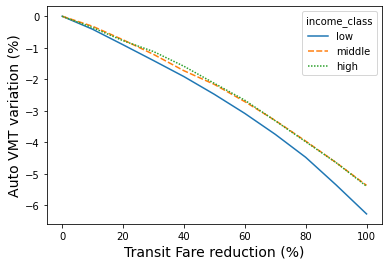

In [7]:
variable = 'income_class'
plot_sensitivy_analysis(variable)

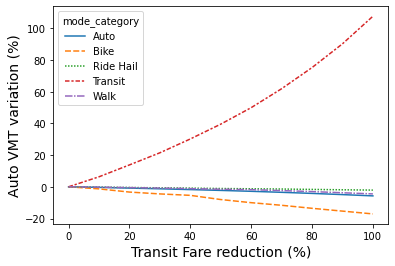

In [97]:
variable = 'mode_category'
plot_sensitivy_analysis(variable)

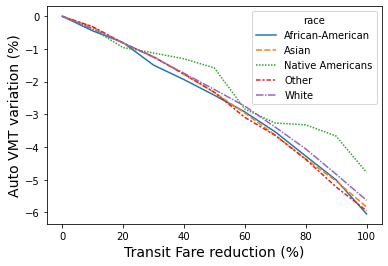

In [98]:
variable = 'race'
plot_sensitivy_analysis(variable)

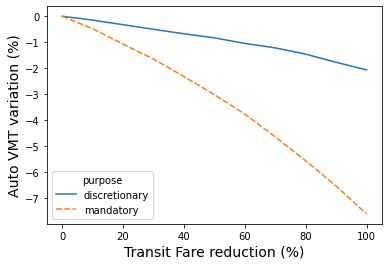

In [107]:
variable = 'purpose'
plot_sensitivy_analysis(variable)

In [28]:
skims = omx.open_file('bay_area_base/data/skims.omx','r')
dist = np.array(skims['DIST'])
skims.close()

In [100]:
hdf_store = pd.HDFStore('transit/reduction_0/output/final_output_tables.h5')
trips = hdf_store['/trips']
persons = hdf_store['/persons']
households = hdf_store['/households']
hdf_store.close()

In [103]:
purpose = {'othmaint': 'discretionary', 'eatout': 'discretionary', 
           'school': 'mandatory', 'othdiscr': 'discretionary', 
           'work': 'mandatory', 'atwork': 'mandatory','shopping': 'discretionary',
           'escort': 'discretionary', 'univ': 'mandatory', 'social': 'discretionary'}
trips.primary_purpose.unique()

array(['othmaint', 'eatout', 'school', 'othdiscr', 'work', 'atwork',
       'shopping', 'escort', 'univ', 'social'], dtype=object)

In [44]:
variable = 'income_class'
vmt_list = []
for scenario in models:
    logging.info('Estimating VMT for {}'.format(scenario))
    path = 'transit/' + scenario + '/output/final_output_tables.h5'
    
    hdf_store = pd.HDFStore(path)
    trips = hdf_store['/trips']
    persons = hdf_store['/persons']
    households = hdf_store['/households']
    hdf_store.close()
#     population = persons.shape[0]
    variables = ['hhsize','auto_ownership','income', 'race_of_head']
    
    trips_m = add_vars(trips, households, dist, variables)
    vmt = estimate_vmt(trips_m, variable = variable, scenario = scenario)
    
    vmt_list.append(vmt)

In [81]:
vmt_sensitivity = pd.concat(vmt_list, axis = 1).T

vmt_sensitivity = vmt_sensitivity.set_index(vmt_sensitivity.index.str.extract('(\d+)')[0]\
                                            .rename('scenario')\
                                            .astype(int)).sort_index()
reduction = (vmt_sensitivity/vmt_sensitivity.iloc[0]-1)*100

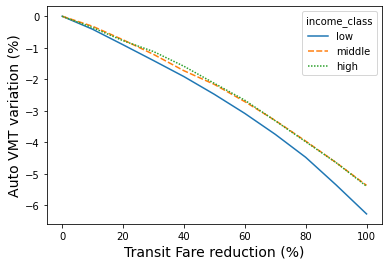

In [83]:
sns.lineplot(data = reduction);
plt.xlabel('Transit Fare reduction (%)', fontsize = 14)
plt.ylabel('Auto VMT variation (%)', fontsize = 14);

## TO DO 
- For Share 2 and 3, devide by 2 and 3 respectively to calculate VMT 
- Create models for other policies 

In [55]:
skims = omx.open_file('bay_area_base/data/skims.omx','r')
dist = np.array(skims['DIST'])
skims.close()
    
path = 'transit'
models = os.listdir(path)
to_drop = ['.ipynb_checkpoints']
models = list(set(models) - set(to_drop))
    
#     variable = 'income_class'
vmt_list = []
for scenario in models:
    logging.info('Estimating VMT for {}'.format(scenario))
    path = 'transit/' + scenario + '/output/final_output_tables.h5'

    hdf_store = pd.HDFStore(path)
    trips = hdf_store['/trips']
    persons = hdf_store['/persons']
    households = hdf_store['/households']
    hdf_store.close()
    
    path = 'transit/' + scenario + '/output/pipeline.h5'
    hdf_store = pd.HDFStore(path)
    accessibilities = hdf_store['/accessibility/trip_mode_choice']
    hdf_store.close()
    #     population = persons.shape[0]
    variables = ['hhsize','auto_ownership','income', 'race_of_head', 'TAZ']

    trips_m = add_vars(trips, households, dist, variables)
    trips_m = trips_m.merge(accessibilities, how = 'left', left_on = 'TAZ', right_index = True)
    
    vmt_list.append(trips_m)
#     vmt = estimate_vmt(trips_m, variable = variable, scenario = scenario)

#     vmt_list.append(vmt)
     
#     #Putting data together
# vmt_sensitivity = pd.concat(vmt_list, axis = 1).T

# vmt_sensitivity = vmt_sensitivity.set_index(vmt_sensitivity.index.str.extract('(\d+)')[0]\
#                                             .rename('scenario')\
#                                             .astype(int)).sort_index()
# reduction = (vmt_sensitivity/vmt_sensitivity.iloc[0]-1)*100
    
#     #Plot
# sns.lineplot(data = reduction);
# plt.xlabel('Transit Fare reduction (%)', fontsize = 14)
# plt.ylabel('Auto VMT variation (%)', fontsize = 14);

In [56]:
def add_vmt_reduced(df):
    ''' Adds VMT considering vehcile occupancy 
    
    Returns:
    - Dataframe with column  VMT '''
    vmt_reducer = {'TNC_SINGLE':1, 'DRIVEALONEFREE':1, 'WALK':1, 'SHARED2FREE':2,
           'SHARED3FREE':3, 'DRIVE_LOC':1, 'TAXI':1, 'TNC_SHARED':2, 'WALK_LOC':1,
           'DRIVE_LRF':1, 'WALK_LRF':1, 'BIKE':1, 'DRIVE_COM':1, 'WALK_HVY':1,
           'WALK_COM':1, 'DRIVEALONEPAY':1, 'DRIVE_HVY':1, 'SHARED2PAY':2, 'WALK_EXP':1,
           'DRIVE_EXP':1, 'SHARED3PAY':3}

#     vmt_list[0]['vmt_reducer'] = vmt_list[0]['trip_mode'].replace(vmt_reducer)
#     vmt_list[0]['vmt'] = vmt_list[0].dist_miles/vmt_list[0].vmt_reducer
#     vmt_list[0][['dist_miles','vmt']]
    df['vmt_reducer'] = df['trip_mode'].replace(vmt_reducer)
    df['vmt'] = df.dist_miles/df.vmt_reducer
    return df 

In [57]:

for i in range(len(vmt_list)):
    vmt_list[i] = add_vmt_reduced(vmt_list[i])


In [58]:
vmt_list_2 = []
i = 0 
for scenario in models:
    vmt = estimate_vmt(vmt_list[i], variable = 'mode_category', scenario = scenario)

    vmt_list_2.append(vmt)
    i += 1 

In [61]:
vmt_list_2[2]

dist_miles(reduction_50)
mode_category                          
Auto                       8.802607e+06
Bike                       6.679853e+04
Ride Hail                  3.583779e+05
Transit                    9.939072e+05
Walk                       1.451645e+05

In [62]:
 #Putting data together
vmt_sensitivity = pd.concat(vmt_list_2, axis = 1).T

vmt_sensitivity = vmt_sensitivity.set_index(vmt_sensitivity.index.str.extract('(\d+)')[0]\
                                            .rename('scenario')\
                                            .astype(int)).sort_index()

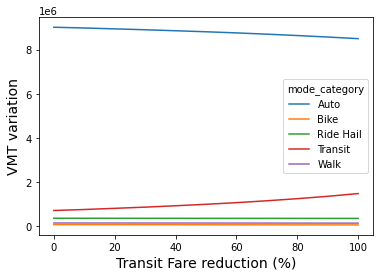

In [67]:
vmt_sensitivity.plot()
plt.xlabel('Transit Fare reduction (%)', fontsize = 14)
plt.ylabel('VMT variation', fontsize = 14);

In [68]:
vmt_sensitivity

mode_category          Auto      Bike  Ride Hail     Transit       Walk
scenario                                                               
0              9.007567e+06  72637.01  362309.08   712391.74  147418.31
10             8.974496e+06  71682.05  361441.41   757332.49  147088.39
20             8.934014e+06  70225.12  360725.60   810715.08  146667.52
30             8.894110e+06  69377.32  359994.11   865192.81  146242.67
40             8.848982e+06  68719.07  359241.94   927359.03  145699.96
50             8.802607e+06  66798.53  358377.89   993907.21  145164.53
60             8.751580e+06  65363.40  357769.78  1068072.81  144750.45
70             8.694027e+06  64165.59  357205.93  1153100.95  143877.19
80             8.632163e+06  62780.34  356343.63  1248219.67  142969.72
90             8.564425e+06  61496.13  355491.14  1354952.97  141872.25
100            8.491761e+06  60211.40  354776.09  1478909.57  140811.26

In [73]:
vmt_sensitivity.iloc[10]['Auto']/vmt_sensitivity.iloc[0]['Auto']

0.9427363529866831

## Mode shares

In [80]:
a = vmt_list[0].mode_category.value_counts()/len(vmt_list[0])

In [82]:
a.name = 'algomas'

In [83]:
a

Auto         0.766431
Walk         0.102803
Transit      0.060348
Ride Hail    0.054102
Bike         0.016317
Name: algomas, dtype: float64

In [91]:
mode_share_list = []
i = 0 
for scenario in models:
    mode_share = vmt_list[i].mode_category.value_counts()/len(vmt_list[i])
    mode_share.name = scenario
    mode_share_list.append(mode_share)
    i += 1 

In [88]:
pd.concat(mode_share_list, axis = 1)

reduction_30  reduction_90  reduction_50  reduction_100  \
Auto           0.766431      0.766431      0.766431       0.766431   
Walk           0.102803      0.102803      0.102803       0.102803   
Transit        0.060348      0.060348      0.060348       0.060348   
Ride Hail      0.054102      0.054102      0.054102       0.054102   
Bike           0.016317      0.016317      0.016317       0.016317   

           reduction_70  reduction_0  reduction_20  reduction_60  \
Auto           0.766431     0.766431      0.766431      0.766431   
Walk           0.102803     0.102803      0.102803      0.102803   
Transit        0.060348     0.060348      0.060348      0.060348   
Ride Hail      0.054102     0.054102      0.054102      0.054102   
Bike           0.016317     0.016317      0.016317      0.016317   

           reduction_10  reduction_40  reduction_80  
Auto           0.766431      0.766431      0.766431  
Walk           0.102803      0.102803      0.102803  
Transit        0.060348      0.060348      0.060348  
Ride Hail      0.054102      0.054102      0.054102  
Bike           0.016317      0.016317      0.016317

In [135]:
vmt_sensitivity = pd.concat(mode_share_list, axis = 1).T

vmt_sensitivity = vmt_sensitivity.set_index(vmt_sensitivity.index.str.extract('(\d+)')[0]\
                                            .rename('scenario')\
                                            .astype(int)).sort_index()

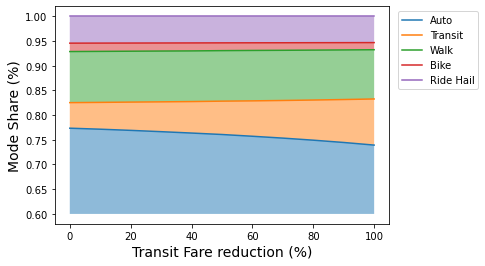

In [134]:
a = vmt_sensitivity[['Auto', 'Transit', 'Walk', 'Bike', 'Ride Hail']].cumsum(axis = 1)
a.plot();
a = a.reset_index()
plt.fill_between( a.scenario, a.Auto, [0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6], alpha=0.5)
plt.fill_between( a.scenario, a.Auto, a.Transit, alpha=0.5)
plt.fill_between( a.scenario, a.Transit, a.Walk, alpha=0.5)
plt.fill_between( a.scenario, a.Walk, a.Bike, alpha=0.5)
plt.fill_between( a.scenario, a.Bike, a['Ride Hail'], alpha=0.5)

plt.xlabel('Transit Fare reduction (%)', fontsize = 14)
plt.ylabel('Mode Share (%)', fontsize = 14)
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left");

In [117]:
a

scenario      Auto   Transit      Walk      Bike  Ride Hail
0          0  0.773471  0.825187  0.928550  0.945549        1.0
1         10  0.771421  0.825692  0.928894  0.945657        1.0
2         20  0.769045  0.826272  0.929252  0.945771        1.0
3         30  0.766431  0.826778  0.929581  0.945898        1.0
4         40  0.763637  0.827354  0.929861  0.946012        1.0
5         50  0.760699  0.828184  0.930402  0.946156        1.0
6         60  0.757147  0.828765  0.930781  0.946268        1.0
7         70  0.753394  0.829549  0.931093  0.946345        1.0
8         80  0.749205  0.830445  0.931452  0.946470        1.0
9         90  0.744559  0.831453  0.931850  0.946562        1.0
10       100  0.739269  0.832590  0.932260  0.946685        1.0

In [136]:
vmt_sensitivity

Auto      Walk   Transit  Ride Hail      Bike
scenario                                                   
0         0.773471  0.103363  0.051717   0.054451  0.016999
10        0.771421  0.103202  0.054271   0.054343  0.016762
20        0.769045  0.102980  0.057226   0.054229  0.016520
30        0.766431  0.102803  0.060348   0.054102  0.016317
40        0.763637  0.102508  0.063717   0.053988  0.016151
50        0.760699  0.102218  0.067485   0.053844  0.015755
60        0.757147  0.102016  0.071618   0.053732  0.015487
70        0.753394  0.101544  0.076155   0.053655  0.015252
80        0.749205  0.101007  0.081240   0.053530  0.015018
90        0.744559  0.100398  0.086894   0.053438  0.014712
100       0.739269  0.099670  0.093321   0.053315  0.014424

## Accessibility by income 

In [144]:
np.percentile(vmt_list[0].income, 10, axis = 0)#.percentile(0.1)

25050.0

In [164]:
df = vmt_list[0]

In [170]:
df['income_q'] = pd.qcut(df.income, q = np.linspace(0,1, 101), labels = list(np.linspace(0.01,1, 100))).astype(float)

In [167]:
df.columns

Index(['person_id', 'household_id', 'tour_id', 'primary_purpose', 'trip_num',
       'outbound', 'trip_count', 'purpose', 'destination', 'origin',
       'destination_logsum', 'depart', 'trip_mode', 'mode_choice_logsum',
       'dist_miles', 'mode_category', 'hhsize', 'auto_ownership', 'income',
       'race_of_head', 'TAZ', 'income_class', 'race', 'auPkRetail',
       'auPkTotal', 'auOpRetail', 'auOpTotal', 'trPkRetail', 'trPkTotal',
       'trOpRetail', 'trOpTotal', 'nmRetail', 'nmTotal', 'vmt_reducer', 'vmt',
       'income_q'],
      dtype='object')

<AxesSubplot:xlabel='income_q'>

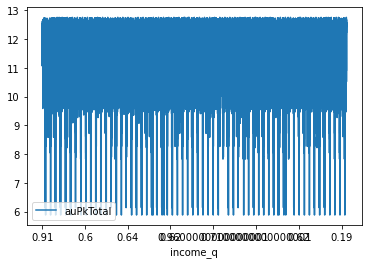

In [168]:
df.plot(x = 'income_q', y='auPkTotal' )

In [173]:
df = df.drop_duplicates(subset = ['household_id'])

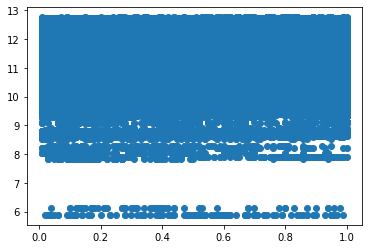

In [175]:
plt.scatter(df['income_q'], df['auPkTotal'])

In [177]:
accessibilities['auto_transit_diff'] = accessibilities['auPkTotal'] - accessibilities['trPkTotal']

<AxesSubplot:>

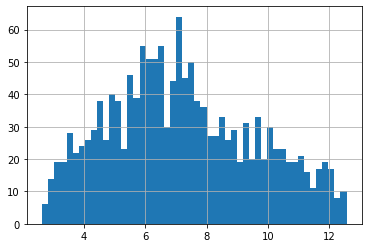

In [211]:
accessibilities['auto_transit_diff'].hist(bins = 50)

In [215]:
accessibilities['trPkTotal'].min()

0.0

In [183]:
df = vmt_list[0]

In [192]:
df['transit_dependent'] = (df['auto_ownership'] == 0).astype(int)
df['auto_dependent'] = (df['auto_ownership'] > 0).astype(int)

In [216]:
dep = df.groupby(['TAZ']).agg({'transit_dependent':'mean', 'auto_dependent':'mean', 'income':'mean'})

In [217]:
a = accessibilities.merge(dep, how = 'left', left_index = True, right_index = True)

In [218]:
a['nominator'] = a['trPkTotal']*a['transit_dependent']
a['denominator'] = a['auPkTotal']*a['auto_dependent']
a['nominator'].sum()/a['denominator'].sum()

0.014078939591626302

In [202]:
a['nominator'].sum()/a['denominator'].sum()

0.014078939591626302

In [221]:
import seaborn as sns

/home/ubuntu/anaconda3/envs/asim/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='income', ylabel='auPkTotal'>

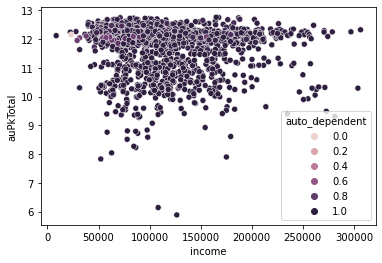

In [233]:
sns.scatterplot('income', 'auPkTotal', data = a, hue = 'auto_dependent')
#
# sns.scatterplot('income', 'trPkTotal', data = a, hue = 'transit_dependent' )

/home/ubuntu/anaconda3/envs/asim/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='income', ylabel='auto_transit_diff'>

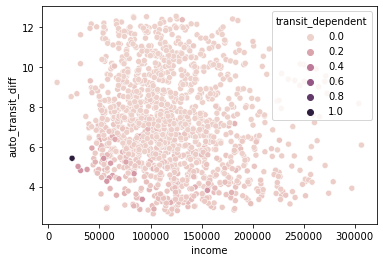

In [228]:
# plt.scatter(a.income, a.auto_transit_diff)
sns.scatterplot('income', 'auto_transit_diff', data = a, hue = 'transit_dependent' )

In [219]:
a.head(50)

auPkRetail  auPkTotal  auOpRetail  auOpTotal  trPkRetail  trPkTotal  \
TAZ                                                                        
1     10.005004  12.230941   10.020243  12.249259    7.392755   9.603876   
2     10.021226  12.246075   10.033625  12.261752    7.189913   9.389905   
3     10.016246  12.236854   10.037102  12.260587    6.942885   9.180338   
4     10.054542  12.278127   10.069808  12.296092    7.459714   9.647141   
5     10.062051  12.279601   10.077505  12.298249    7.357976   9.546230   
6     10.047805  12.256695   10.075534  12.287180    6.776221   9.017824   
7     10.070595  12.279931   10.101618  12.313921    7.085437   9.325001   
8     10.089387  12.295820   10.119815  12.329268    7.253179   9.391379   
9     10.128507  12.331018   10.159772  12.364879    6.893828   9.220580   
10    10.155838  12.366021   10.189408  12.402906    7.179849   9.293258   
11    10.131880  12.345680   10.164070  12.381126    7.169780   9.322929   
12    10.062023  12.285140   10.077746  12.303817    7.242866   9.463360   
13    10.043675  12.271559   10.059006  12.289910    7.165850   9.347265   
14    10.022033  12.251219   10.042193  12.274458    7.253555   9.427523   
15     9.987606  12.217486   10.017043  12.249771    6.940809   9.257213   
16    10.029970  12.260047   10.062344  12.295287    6.494862   8.728974   
17    10.068127  12.297379   10.102233  12.335066    5.985541   8.214280   
18    10.114457  12.337100   10.147243  12.374443    6.568372   8.810497   
19    10.119722  12.336841   10.156652  12.377734    6.137894   8.235826   
20    10.141668  12.356520   10.174492  12.392853    6.387741   8.513875   
21    10.122476  12.341630   10.158354  12.381764    6.828119   9.012951   
22     9.937123  12.166169    9.953670  12.185675    6.956909   9.218084   
23     9.870910  12.107190    9.899071  12.137510    5.752795   7.891264   
24     9.959308  12.187897    9.971547  12.202730    6.905775   9.172135   
25     9.950898  12.174569    9.973824  12.199274    7.082783   9.279650   
26     9.994464  12.216036   10.016672  12.240724    7.151642   9.347162   
27     9.962887  12.180541    9.991251  12.211035    7.121417   9.328727   
28    10.006285  12.217530   10.034413  12.248075    7.246750   9.426991   
29    10.042958  12.252891   10.069997  12.283025    6.873440   9.046727   
30    10.087190  12.291916   10.120749  12.327981    7.024910   9.216652   
31    10.049316  12.254509   10.080826  12.288027    7.028928   9.220813   
32    10.022266  12.227272   10.054374  12.261100    6.898347   9.187233   
33     9.954784  12.161475    9.990492  12.198139    6.941131   9.167812   
34     9.889092  12.095153    9.928943  12.136212    6.840673   9.064226   
35     9.949391  12.160034    9.980624  12.192567    6.660833   8.890797   
36     9.881424  12.102091    9.912340  12.134274    6.675558   8.894917   
37     9.872295  12.100376    9.892897  12.123270    6.528837   8.840347   
38     9.814330  12.049597    9.836819  12.072686    6.087081   8.405980   
39     9.842651  12.056729    9.877179  12.091118    6.345304   8.706344   
40     9.832036  12.047846    9.872764  12.087700    6.442287   8.658664   
41     9.817921  12.044175    9.852336  12.077015    6.553525   8.844781   
42     9.383009  11.615193    9.752570  11.982377    2.968906   5.216029   
43     9.807331  12.013883    9.868815  12.073558    5.985044   8.299353   
44     9.855510  12.062009    9.905200  12.110662    6.377331   8.628916   
45     9.861557  12.066459    9.911320  12.115720    6.282671   8.527868   
46     9.991798  12.197915   10.032320  12.239776    6.882143   9.054637   
47     9.929042  12.134026    9.971233  12.176293    6.780525   9.005402   
48     9.928820  12.130118    9.971407  12.172427    6.772434   8.914993   
49     9.882425  12.085993    9.932513  12.135582    6.125684   8.428844   
50     9.803776  12.004813    9.859107  12.059734    6.238016   8.466885   

     trOpRetail  trOpTotal  nmRetail   nmTotal  auto